In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [ ]:
!pip install umap

In [3]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
sys.path.append("/home/Developer/NCSN-TF2.0/")

import PIL
import utils, configs
import argparse
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from helper import plot_confusion_matrix, metrics

from ood_detection_helper import *
from datasets.dataset_loader import  *
from tqdm import tqdm
from sklearn.metrics import classification_report, average_precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from PIL import Image
from IPython.display import display
from matplotlib.pyplot import imshow
from datetime import datetime

import seaborn as sns
import plotly as py
import plotly.graph_objs as go

# import umap
from sklearn.preprocessing import MinMaxScaler 

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 16

sns.set(style="darkgrid")
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16

seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.experimental.list_physical_devices('GPU'))
tf.__version__

Num GPUs Available:  0
[]


'2.3.1'

## Loading OOD datasets

In [4]:
with open("train_scores_100_0.p", "rb") as f:
    train_scores = pickle.load(f)
train_scores.shape

(50000, 10)

In [5]:
with open("scores_ckpt-9.p", "rb") as f:
    score_dict = pickle.load(f)
score_dict.keys()

dict_keys(['cifar', 'celeba', 'svhn'])

In [6]:
inlier_scores = score_dict["cifar"]
outlier_scores = [score_dict["celeba"], score_dict["svhn"]]

In [7]:
with open("ood_scores_ckpt-9.p", "rb") as f:
    ood_dict = pickle.load(f)
outlier_scores.extend([x for x in ood_dict.values()])

In [10]:
train_scores

array([[29.757946, 27.524782, 25.461084, ..., 23.771935, 22.455229,
        22.076267],
       [29.68054 , 28.38256 , 26.831451, ..., 24.068005, 23.54544 ,
        24.104277],
       [30.657694, 29.998894, 29.920216, ..., 28.031355, 25.104092,
        23.336847],
       ...,
       [30.948917, 29.274868, 28.21821 , ..., 26.252281, 25.347403,
        25.30215 ],
       [30.299294, 28.52503 , 25.761595, ..., 25.467283, 28.213076,
        29.921135],
       [37.54625 , 36.58703 , 35.118263, ..., 30.12391 , 27.832844,
        26.227633]], dtype=float32)

In [11]:
(train_scores ** 2).shape

(50000, 10)

In [12]:
megadict = {}
megadict["train"] = train_scores ** 2
megadict["cifar"] = score_dict["cifar"] ** 2
megadict["svhn"] = score_dict["svhn"] ** 2

for k,v in ood_dict.items():
    megadict[k] = v ** 2

megadict.keys()

dict_keys(['train', 'cifar', 'svhn', 'LSUN', 'LSUN_resize', 'Imagenet', 'Imagenet_resize', 'iSUN', 'gaussian', 'uniform'])

In [8]:
# with open("../ablation/SH1_L10.p", "wb") as f:
#     pickle.dump(megadict, f)

In [13]:
non_synthetic_images = ['LSUN','LSUN_resize', 'Imagenet', 'Imagenet_resize', 'iSUN']
outlier_scores.append(np.concatenate([ood_dict[n].numpy() for n in non_synthetic_images]))

In [14]:
ood_names = list(score_dict.keys())[1:] + list(ood_dict.keys()) + ["All Images"]
ood_names, len(outlier_scores)

(['celeba',
  'svhn',
  'LSUN',
  'LSUN_resize',
  'Imagenet',
  'Imagenet_resize',
  'iSUN',
  'gaussian',
  'uniform',
  'All Images'],
 10)

In [15]:
LABELS = np.array(["Train", "CIFAR", "CelebA", "SVHN", 'LSUN','LSUN_resize',
                   'TinyImagenet','Imagenet_resize','iSUN',"Gaussian", "Uniform", "All Images"])
COLORS = sns.color_palette("bright")

## Separation for lowest Sigma 

In [16]:
cifar_score = inlier_scores[:, -1]
ood_scores = np.array([ood[:,-1] for ood in outlier_scores])

In [17]:
def evaluate_model(train_score, inlier_score, outlier_scores, labels, ylim=None, xlim=None, **kwargs):
    rows = 1 + int(np.ceil(len(outlier_scores)/2))
    fig, axs = plt.subplots(rows, 1, figsize=(14,rows*4))
    axs = np.array(axs).reshape(-1) # Makes axs into list even if row num is 1
    colors = sns.color_palette("bright") + sns.color_palette("dark")
    
    sns.distplot(train_score, color=colors[0], label=labels[0], ax=axs[0], **kwargs)
    sns.distplot(inlier_score, color=colors[1], label=labels[1], ax=axs[0], **kwargs)
    
    offset = 2
    for idx, _score in enumerate(outlier_scores):
        idx += offset
        sns.distplot(_score, color=colors[idx], label=labels[idx], ax=axs[0], **kwargs)    

    # Plot in pairs    
    if len(outlier_scores) > 0 :
        offset = 0
        for row in range(1, axs.shape[0]):
            sns.distplot(inlier_score, color=colors[1], label=labels[1], ax=axs[row], **kwargs)
            
    #         for idx in range(offset, min(len(outlier_sc)offset+2)):
            for idx, _score in enumerate(outlier_scores[offset: offset+2]):
                idx += offset + 2
                sns.distplot(_score, color=colors[idx], label=labels[idx], ax=axs[row], **kwargs)    
            offset = 2 * row
        
    for ax in axs:
        ax.legend()
        ax.set_ylim(top=ylim)
        ax.set_xlim(left=xlim, right=100 if xlim else None)

#     plt.show()
    
    return axs

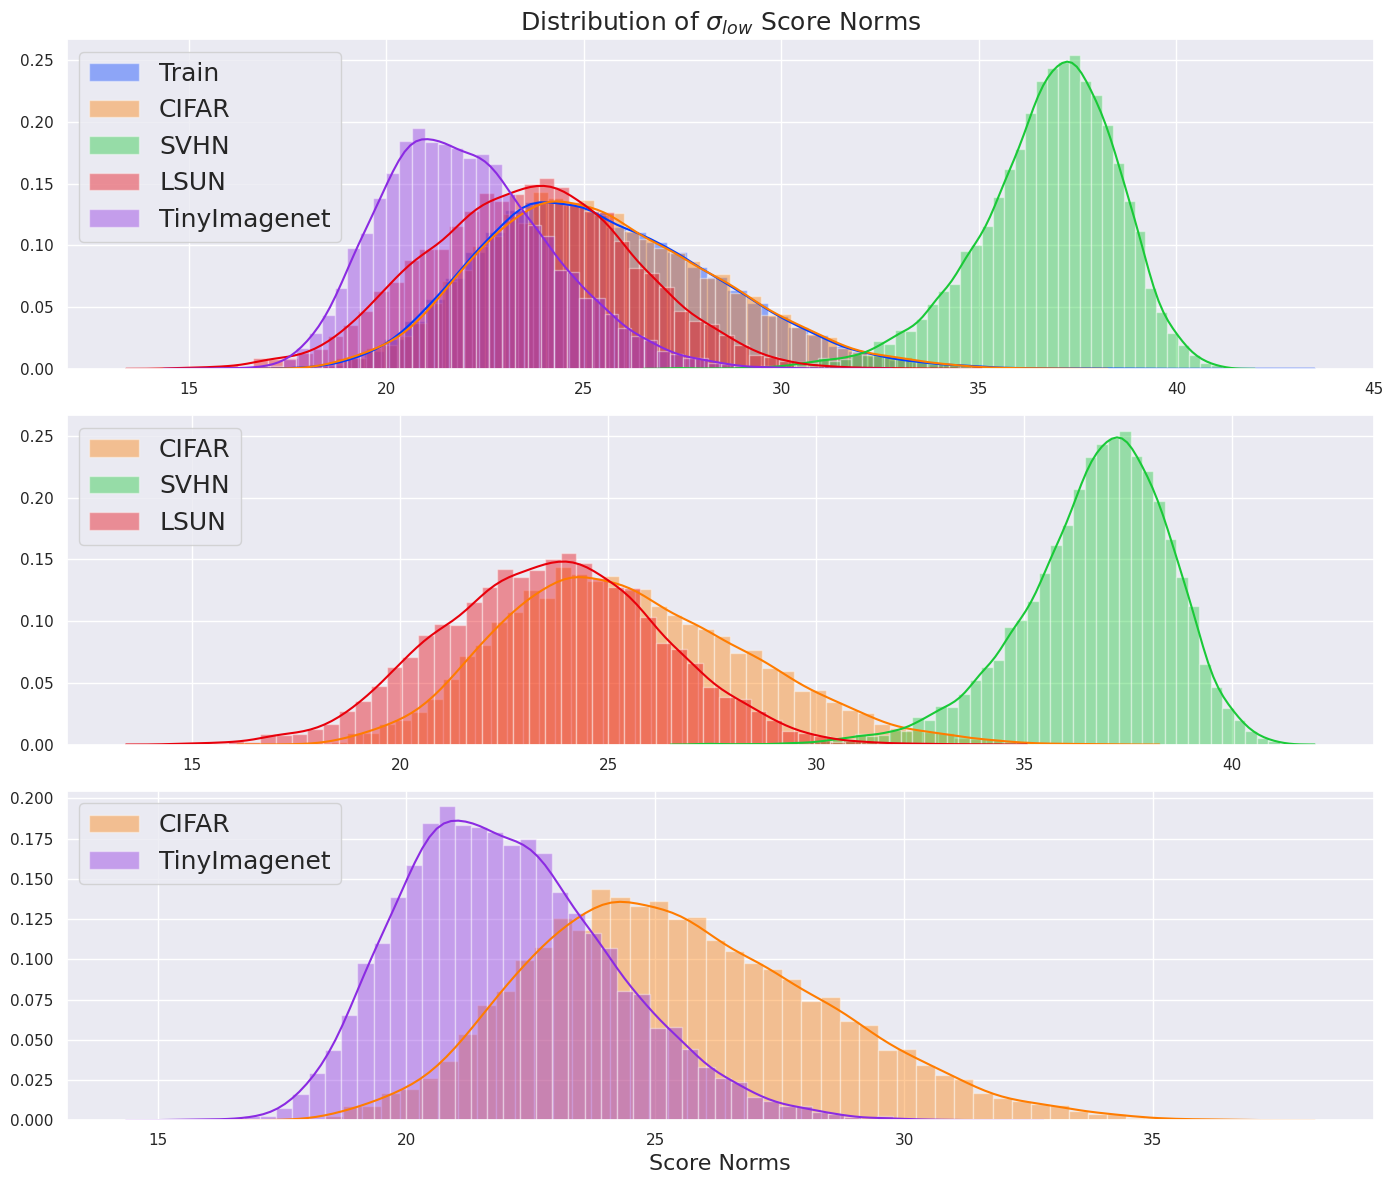

In [18]:
test_idxs=[1,2,4]
label_idxs = [0,1,3,4,6]
axs = evaluate_model(train_scores[:,-1], cifar_score, ood_scores[test_idxs], labels=LABELS[label_idxs])
axs[0].set(
    title=r"Distribution of $\sigma_{low}$ Score Norms",
)
axs[-1].set(
    xlabel="Score Norms"
)
for ax in axs:
    ax.legend(fontsize=18, loc=2)
plt.tight_layout()
# plt.savefig("./low_sigma.png", dpi=200)

# Auxiliary model analysis

In [19]:
# Train Data = L2-norm(Pixel Scores)
X_train, X_test =  train_scores.copy(), inlier_scores.copy()

========================= Training GMM =========================
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   17.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  2.0min finished


Best: 2.538232 using {'GMM__covariance_type': 'full', 'GMM__n_components': 20}
---------------------------------------------------------------------------
2.104536 (0.049753) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
2.345533 (0.048757) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
2.431551 (0.050358) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 6}
2.453731 (0.047474) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 8}
2.487559 (0.043946) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 10}
2.508280 (0.042152) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 12}
2.520068 (0.044660) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 14}
2.531929 (0.040257) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 16}
2.532519 (0.042691) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 18}
2.538232 (0.046117) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 20}


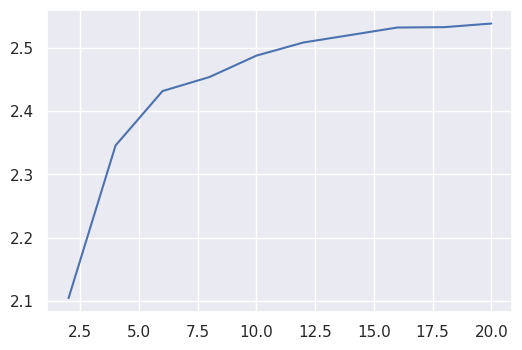

---Likelihoods---
Training: 2.569
CIFAR: 2.427
CelebA: 0.762
SVHN: -3.936
LSUN: -1115.789
LSUN_resize: -614.465
TinyImagenet: -655.023
Imagenet_resize: -806.218
iSUN: -666.070
Gaussian: -396.017
Uniform: -517.603
All Images: -773.830
Epoch 1/1000
390/390 [==============================] - 1s 3ms/step - loss: 3522.8276 - val_loss: 1875.2366
Epoch 2/1000
390/390 [==============================] - 1s 3ms/step - loss: 1366.0125 - val_loss: 1041.3522
Epoch 3/1000
390/390 [==============================] - 1s 3ms/step - loss: 877.3930 - val_loss: 756.0608
Epoch 4/1000
390/390 [==============================] - 1s 3ms/step - loss: 676.0023 - val_loss: 612.2483
Epoch 5/1000
390/390 [==============================] - 1s 3ms/step - loss: 568.7737 - val_loss: 535.4075
Epoch 6/1000
390/390 [==============================] - 1s 3ms/step - loss: 511.2812 - val_loss: 493.2720
Epoch 7/1000
390/390 [==============================] - 1s 3ms/step - loss: 478.6977 - val_loss: 467.5243
Epoch 8/1000
390/390

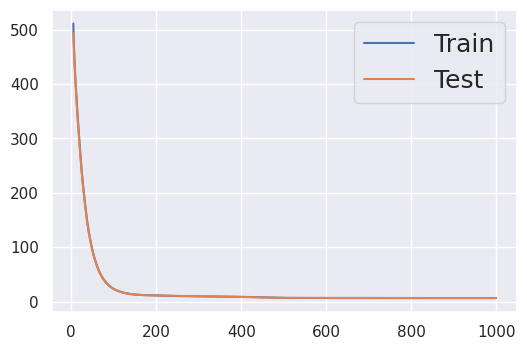

========================= Training KD Tree =========================
CPU times: user 1h 11min 21s, sys: 26min 34s, total: 1h 37min 56s
Wall time: 20min 55s


In [32]:
%%time
results = auxiliary_model_analysis(X_train, X_test, outlier_scores, LABELS, flow_epochs=1000)

## GMM

In [22]:
results["GMM"]["metrics"]

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
CelebA,80.90,36.995000,67.707936,63.824715,68.326530,55.18,63.837911
SVHN,10.59,7.690000,95.886366,92.491827,97.107135,5.88,92.499903
LSUN,0.00,0.020000,99.999854,99.999855,99.999854,0.00,99.999855
LSUN_resize,0.00,0.045000,99.999584,99.999590,99.999581,0.00,99.999590
TinyImagenet,0.00,0.040000,99.999925,99.999925,99.999925,0.00,99.999925
Imagenet_resize,0.00,0.020000,99.999973,99.999973,99.999973,0.00,99.999973
iSUN,0.00,0.026204,99.999464,99.999424,99.999513,0.00,99.999424
Gaussian,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
Uniform,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
All Images,0.00,0.033396,99.999767,99.999952,99.998846,0.00,99.999953


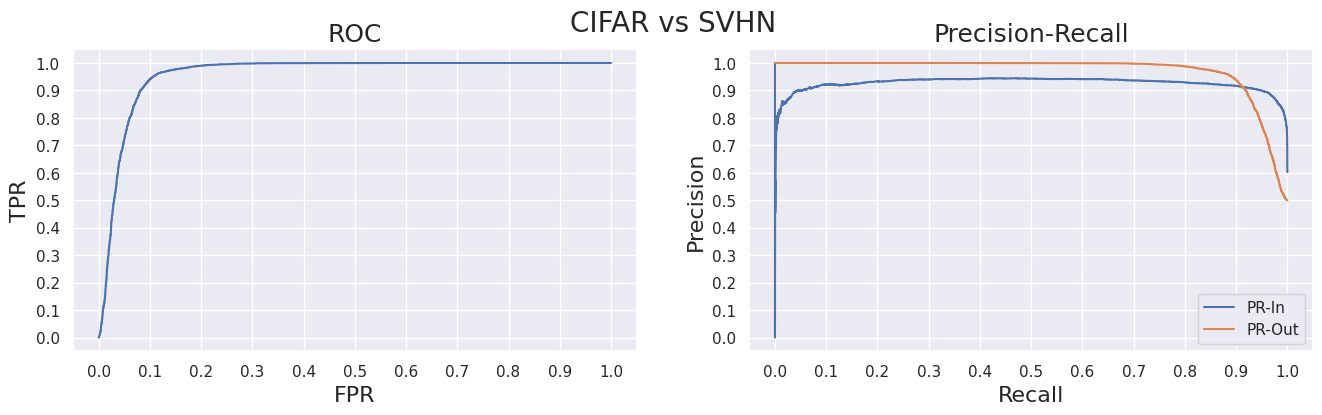

CIFAR vs SVHN
----------------
ROC-AUC: 95.8864
PR-AUC (In/Out): 92.4918 / 97.1071
FPR (95% TPR): 10.59%
Detection Error: 7.69%


{'fpr_tpr95': 0.1059,
 'de': 0.07689999999999997,
 'roc_auc': 0.95886366,
 'pr_auc_in': 0.924918274720641,
 'pr_auc_out': 0.9710713512863963,
 'fpr_tpr80': 0.0588,
 'ap': 0.924999025207306}

In [23]:
ood_metrics(-results["GMM"]["test_scores"], -results["GMM"]["ood_scores"][1], names=(LABELS[1], LABELS[3]), plot=True, verbose=True)

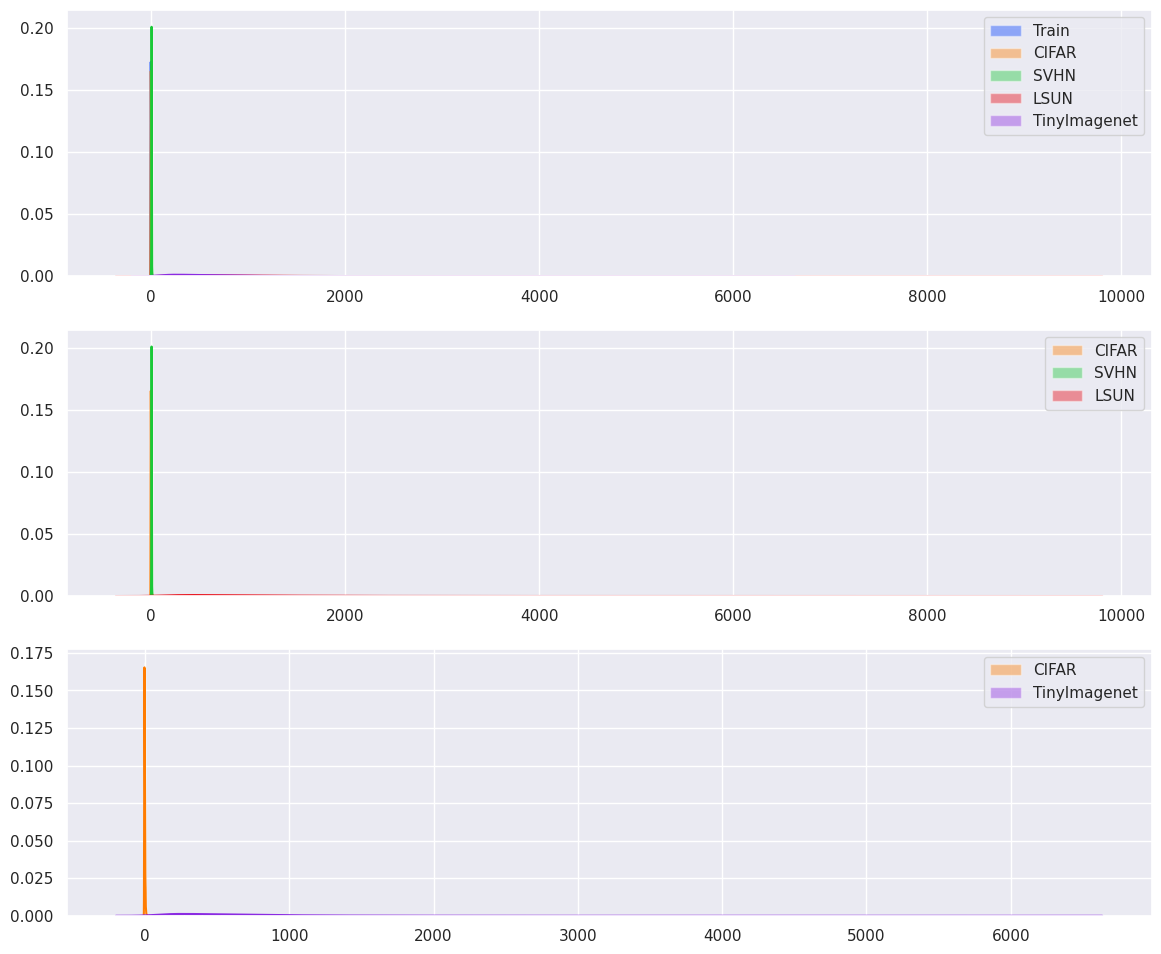

In [24]:
axs=evaluate_model(-results["GMM"]["train_scores"], -results["GMM"]["test_scores"],
               -results["GMM"]["ood_scores"][test_idxs], labels=LABELS[label_idxs])

### Validation Check

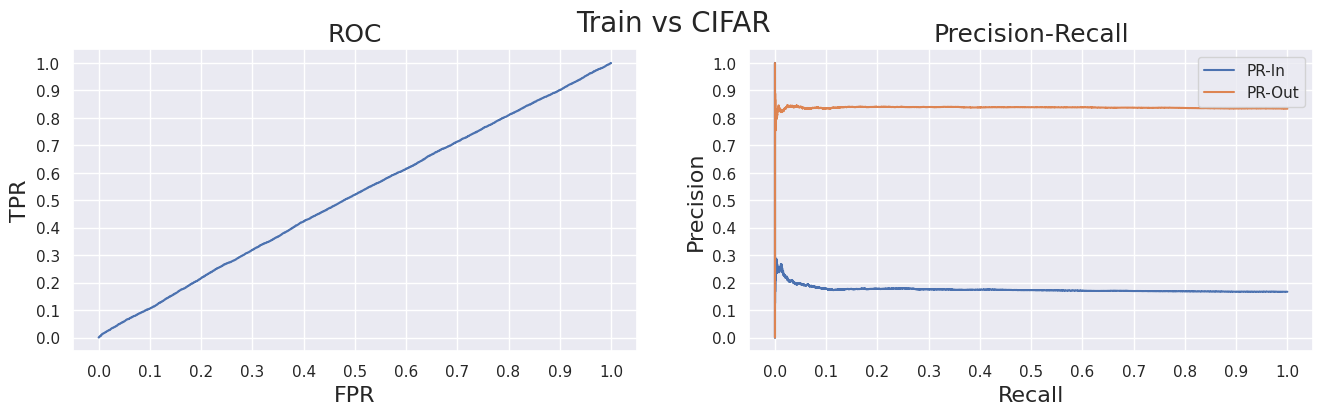

Train vs CIFAR
----------------
ROC-AUC: 51.2894
PR-AUC (In/Out): 17.4957 / 83.7403
FPR (95% TPR): 94.75%
Detection Error: 48.80%


{'fpr_tpr95': 0.94746,
 'de': 0.48797999999999997,
 'roc_auc': 0.512894474,
 'pr_auc_in': 0.17495683821073738,
 'pr_auc_out': 0.8374034887872269,
 'fpr_tpr80': 0.78028,
 'ap': 0.1750495543643971}

In [68]:
ood_metrics(-results["GMM"]["train_scores"], -results["GMM"]["test_scores"], names=(LABELS[0], LABELS[1]), plot=True, verbose=True)

## Flow Models

In [25]:
results["Flow"]["metrics"]

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
CelebA,65.71,32.905000,69.759500,61.598370,75.320868,45.86,61.609637
SVHN,26.44,11.965000,94.481877,93.897259,94.425911,6.12,93.903377
LSUN,0.22,1.560000,99.865878,99.876339,99.860371,0.00,99.876344
LSUN_resize,0.52,1.820000,99.844245,99.850602,99.843297,0.02,99.850609
TinyImagenet,0.59,1.925000,99.803278,99.815207,99.798408,0.03,99.815216
Imagenet_resize,0.16,1.080000,99.941826,99.942987,99.942341,0.00,99.942990
iSUN,0.31,1.531008,99.891573,99.882771,99.903348,0.01,99.882777
Gaussian,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
Uniform,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
All Images,0.38,1.623753,99.868872,99.973097,99.408383,0.01,99.973097


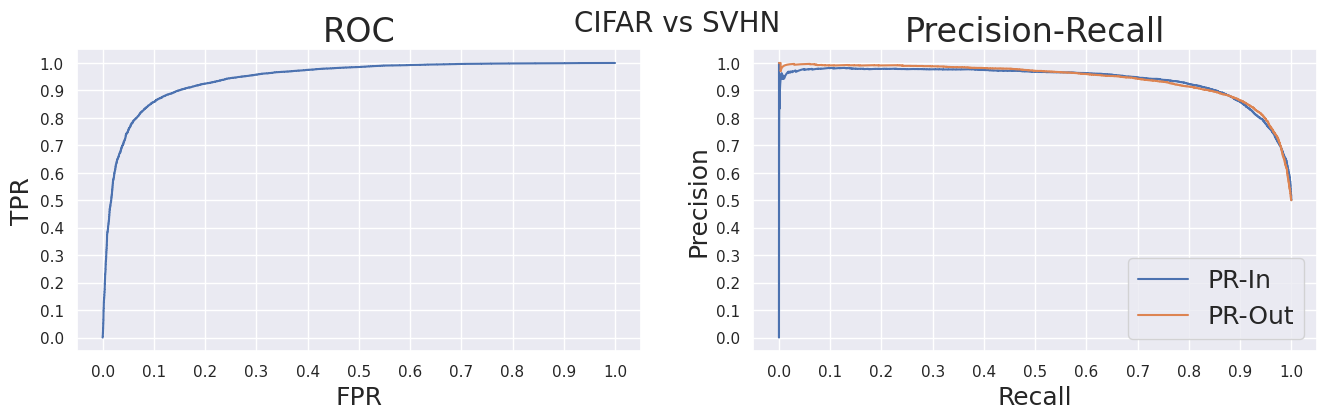

CIFAR vs SVHN
----------------
ROC-AUC: 94.4819
PR-AUC (In/Out): 93.8973 / 94.4259
FPR (95% TPR): 26.44%
Detection Error: 11.96%


{'fpr_tpr95': 0.2644,
 'de': 0.11964999999999999,
 'roc_auc': 0.9448187650000001,
 'pr_auc_in': 0.9389725899814437,
 'pr_auc_out': 0.9442591062173151,
 'fpr_tpr80': 0.0612,
 'ap': 0.9390337737317773}

In [31]:
ood_metrics(-results["Flow"]["test_scores"], -results["Flow"]["ood_scores"][1], names=(LABELS[1], LABELS[3]), plot=True, verbose=True)

### Validation Check

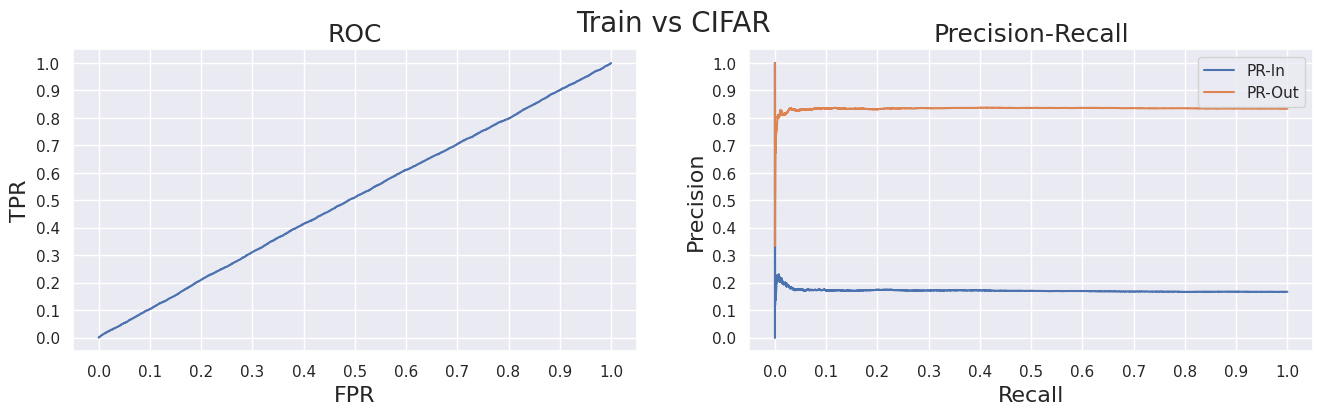

Train vs CIFAR
----------------
ROC-AUC: 50.6100
PR-AUC (In/Out): 17.0486 / 83.3964
FPR (95% TPR): 95.07%
Detection Error: 49.24%


{'fpr_tpr95': 0.9507,
 'de': 0.49239,
 'roc_auc': 0.5061003839999999,
 'pr_auc_in': 0.1704860542039538,
 'pr_auc_out': 0.8339636784848945,
 'fpr_tpr80': 0.79204,
 'ap': 0.1705627132508046}

In [71]:
ood_metrics(-results["Flow"]["train_scores"], -results["Flow"]["test_scores"], names=(LABELS[0], LABELS[1]), plot=True, verbose=True)

## KD Trees w/ k=5

In [26]:
results["KD"]["metrics"]

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
CelebA,78.55,39.265000,62.687221,56.979063,66.537606,57.65,56.991708
SVHN,4.11,4.480000,99.148397,99.069617,99.208808,0.65,99.069714
LSUN,0.23,0.860000,99.946453,99.942667,99.950955,0.03,99.942670
LSUN_resize,0.57,1.450000,99.858522,99.838443,99.874196,0.11,99.838454
TinyImagenet,0.51,1.405000,99.864705,99.843345,99.881427,0.11,99.843356
Imagenet_resize,0.25,0.990000,99.933930,99.926449,99.940817,0.03,99.926454
iSUN,0.39,1.249804,99.892598,99.862438,99.914401,0.06,99.862448
Gaussian,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
Uniform,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
All Images,0.38,1.218327,99.899388,99.976755,99.656194,0.05,99.976755


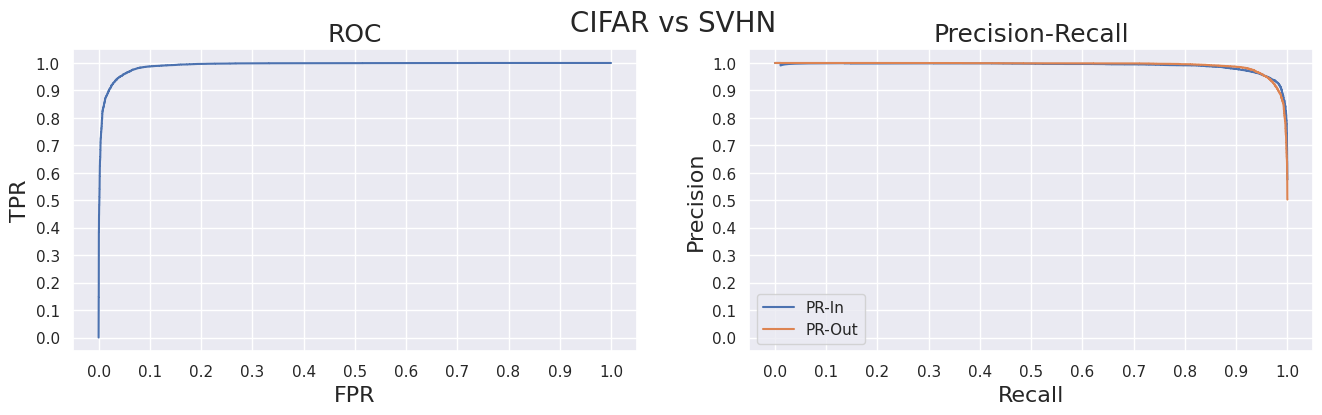

CIFAR vs SVHN
----------------
ROC-AUC: 99.1484
PR-AUC (In/Out): 99.0696 / 99.2088
FPR (95% TPR): 4.11%
Detection Error: 4.48%


{'fpr_tpr95': 0.0411,
 'de': 0.044800000000000006,
 'roc_auc': 0.9914839700000001,
 'pr_auc_in': 0.9906961651441349,
 'pr_auc_out': 0.9920880827440841,
 'fpr_tpr80': 0.0065,
 'ap': 0.9906971353462364}

In [27]:
ood_metrics(results["KD"]["test_scores"], results["KD"]["ood_scores"][1], names=(LABELS[1], LABELS[3]), plot=True, verbose=True)

### Validation Check

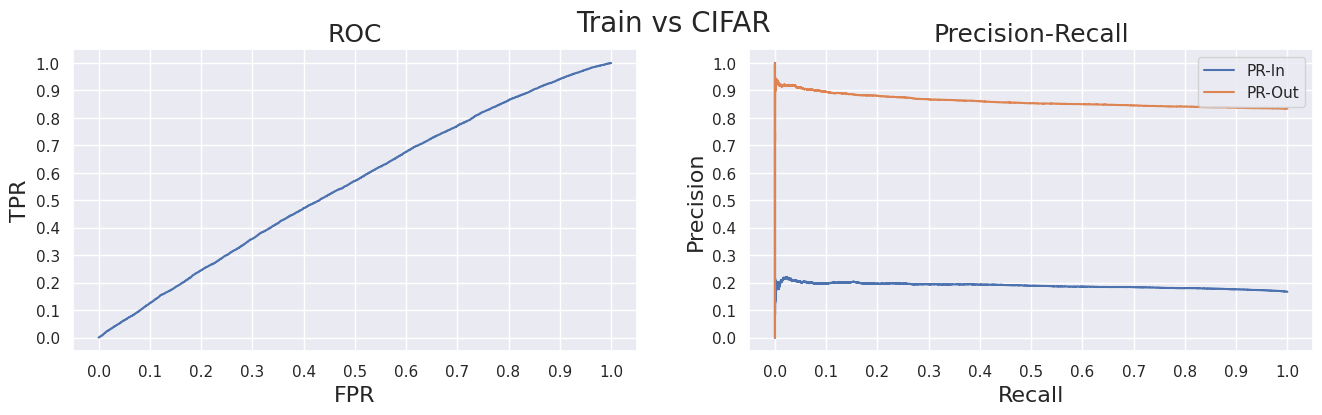

Train vs CIFAR
----------------
ROC-AUC: 55.2840
PR-AUC (In/Out): 18.8324 / 86.0710
FPR (95% TPR): 91.09%
Detection Error: 46.07%


{'fpr_tpr95': 0.91088,
 'de': 0.46065999999999996,
 'roc_auc': 0.552839922,
 'pr_auc_in': 0.18832372951924875,
 'pr_auc_out': 0.8607102295805986,
 'fpr_tpr80': 0.72198,
 'ap': 0.18840465215808516}

In [74]:
ood_metrics(results["KD"]["train_scores"], results["KD"]["test_scores"], names=(LABELS[0], LABELS[1]), plot=True, verbose=True)

In [28]:
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18

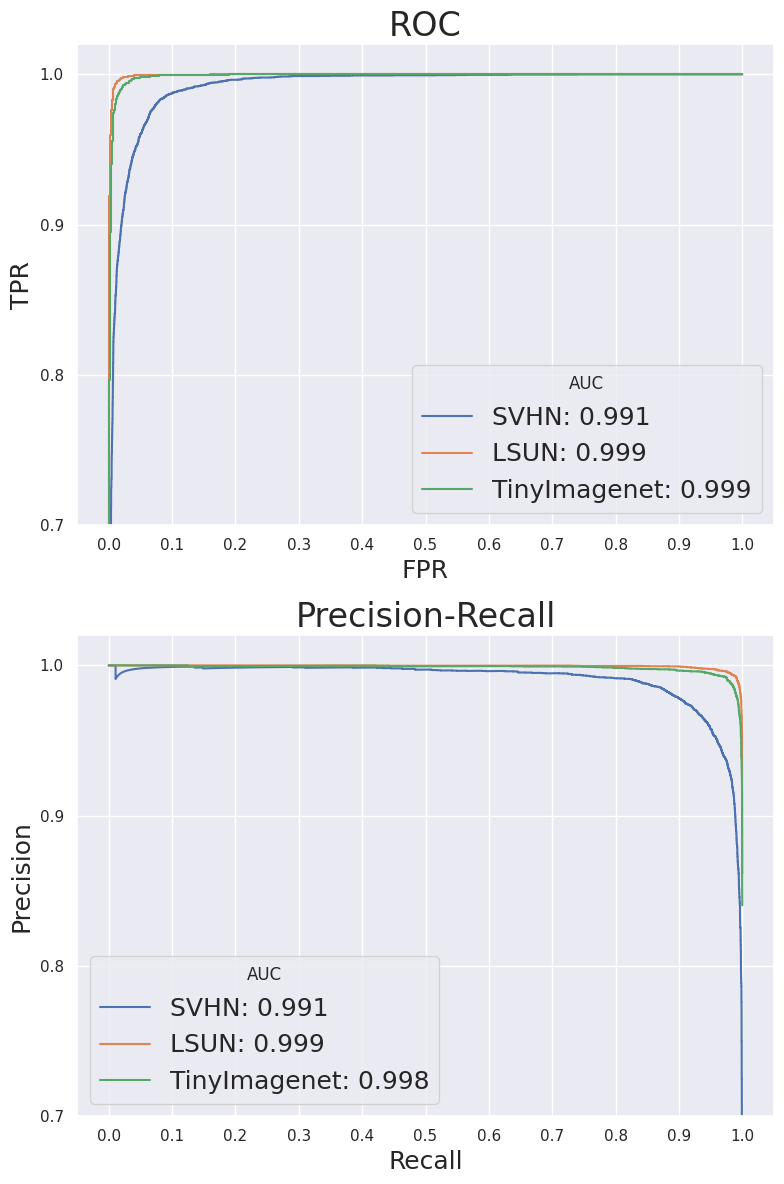

In [29]:
fig, axs = plt.subplots(2,1, figsize=(8,12))
for idx in test_idxs:
    plot_curves(results["KD"]["test_scores"], results["KD"]["ood_scores"][idx], label=LABELS[idx+2], axs=axs)

for ax in axs:
    ax.legend(title="AUC")
    ax.set(ylim=(0.7, 1.02))
plt.tight_layout()
# plt.savefig("./kd_curves.png", dpi=200)

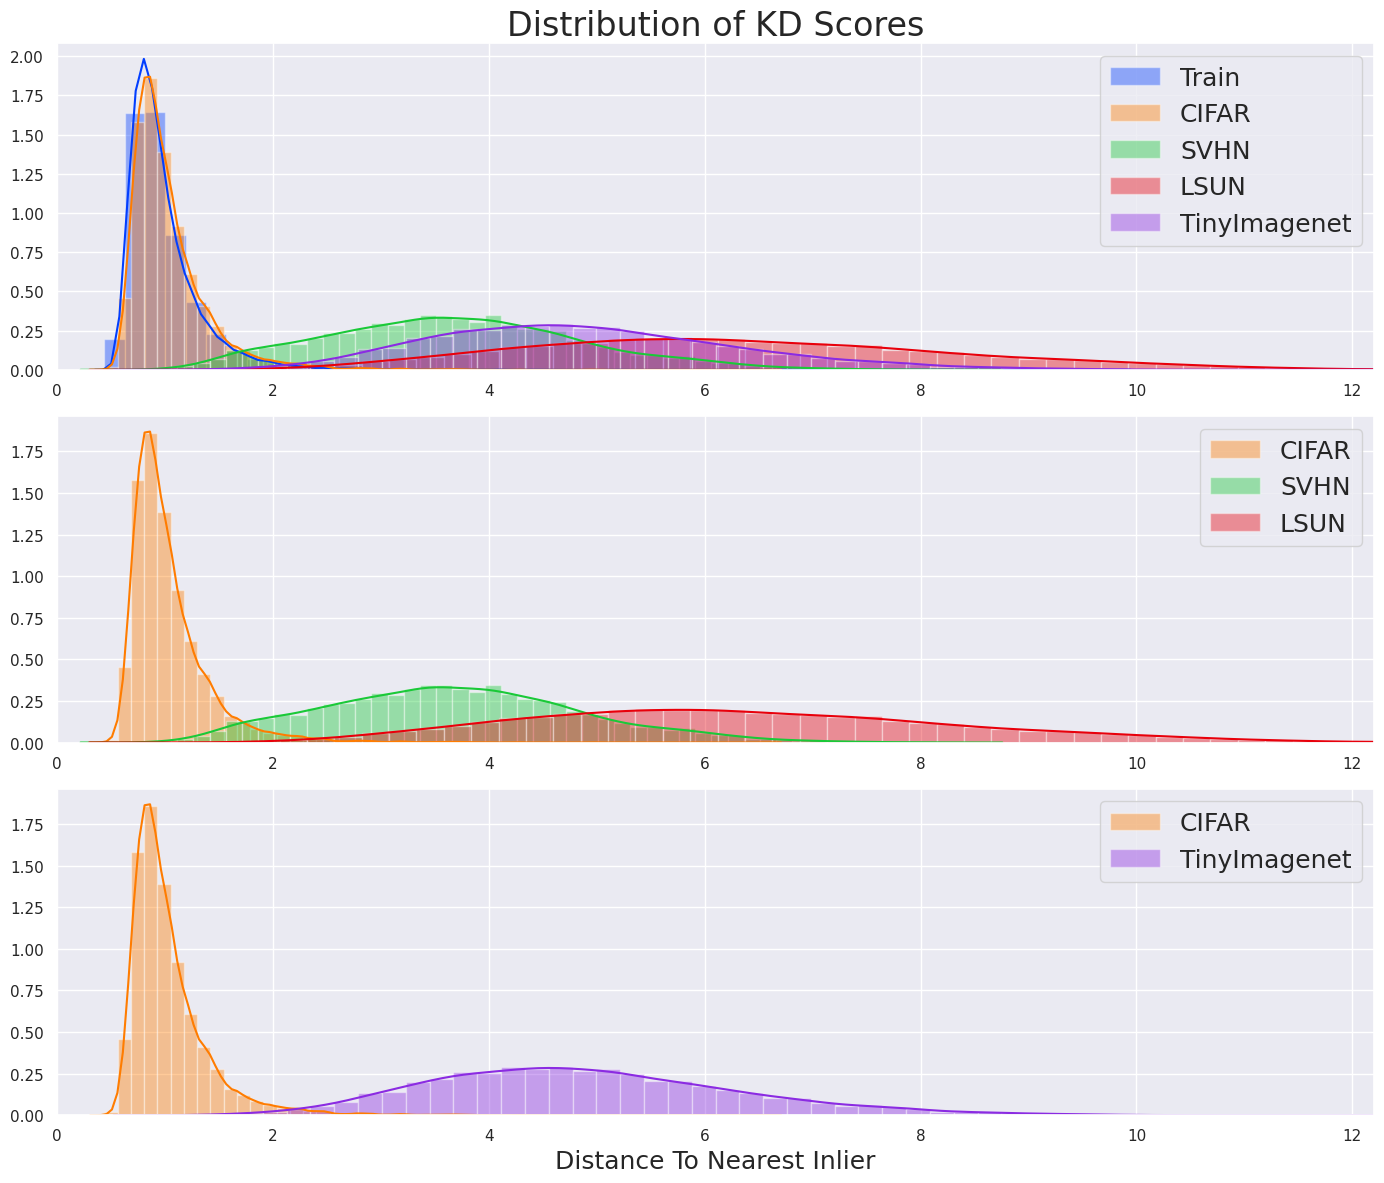

In [30]:
axs = evaluate_model(results["KD"]["train_scores"], results["KD"]["test_scores"],
               np.array(results["KD"]["ood_scores"])[test_idxs], labels=LABELS[label_idxs])

for ax in axs:
    ax.set(xlim = (0,12.2))

axs[0].set(
    title=r"Distribution of KD Scores",
)
axs[-1].set(
    xlabel="Distance To Nearest Inlier"
)
plt.legend()
plt.tight_layout()
# plt.savefig("./kd_scores.png", dpi=200)

## GMM vs Flow vs K-NN Tree on CIFAR vs Any

CIFAR vs SVHN
----------------
ROC-AUC: 99.4791
PR-AUC (In/Out): 99.9322 / 97.1087
FPR (95% TPR): 3.73%
Detection Error: 4.24%
CIFAR vs SVHN
----------------
ROC-AUC: 99.5473
PR-AUC (In/Out): 99.9407 / 97.5845
FPR (95% TPR): 3.23%
Detection Error: 3.68%
CIFAR vs SVHN
----------------
ROC-AUC: 99.8297
PR-AUC (In/Out): 99.9773 / 98.9755
FPR (95% TPR): 0.57%
Detection Error: 1.81%


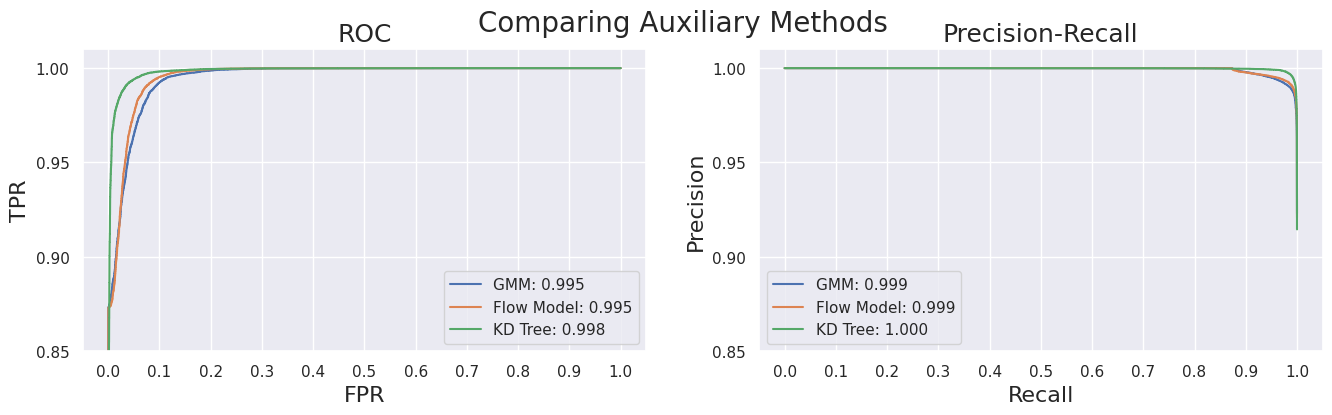

In [114]:
gmm_all = np.concatenate(-results["GMM"]["ood_scores"][1:-1])
flow_all = np.concatenate(-results["Flow"]["ood_scores"][1:-1])
kd_all = np.concatenate(results["KD"]["ood_scores"][1:-1])

pairs = zip(
    ["GMM", "Flow Model", "KD Tree"],
    [-results["GMM"]["test_scores"], -results["Flow"]["test_scores"], results["KD"]["test_scores"]],
    [gmm_all, flow_all, kd_all]
)

fig, axs = plt.subplots(1,2, figsize=(16,4))

for title, cifar_scores, svhn_scores in pairs:
    ood_metrics(cifar_scores, svhn_scores, names=("CIFAR", "SVHN"),plot=False, verbose=True)
    plot_curves(cifar_scores, svhn_scores, title, axs)

for ax in axs:
    ax.set(ylim=(0.85, 1.01), yticks=np.arange(0.85, 1.01, step=0.05))
# axs[1].set(ylim=(0.8, 1.01))

plt.suptitle("Comparing Auxiliary Methods",  fontsize=20)
plt.savefig("./aux.png", dpi=200)

## Bonus analysis with CIFAR 10.1 as train set

In [67]:
with open("cifar101_scores_ckpt-9.p", "rb") as f:
    cifar101_scores = pickle.load(f).numpy()
cifar101_scores.shape

(2000, 10)

========================= Training GMM =========================
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.3s finished


Best: 2.024847 using {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
---------------------------------------------------------------------------
2.024847 (0.181234) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 2}


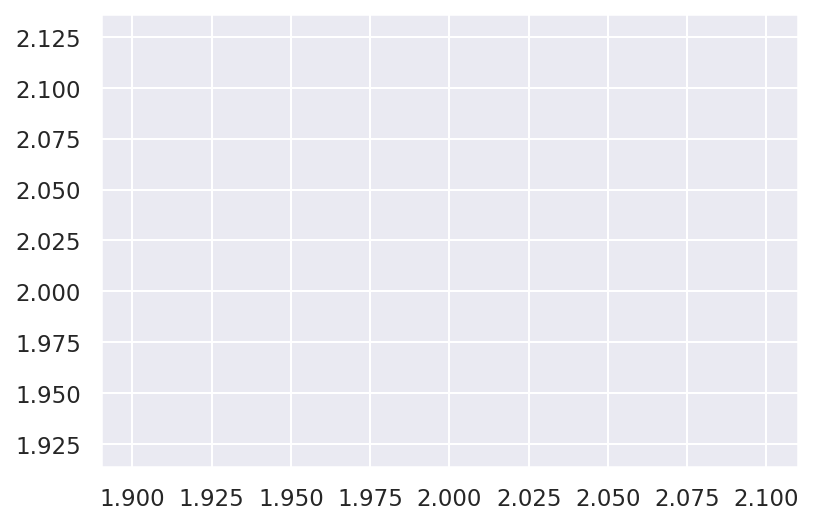

---Likelihoods---
Training: 2.121
CIFAR: 2.036
CelebA: 0.874
SVHN: -6.556
LSUN_crop: -1834.595
LSUN_resize: -946.586
Imagenet_crop: -1028.601
Imagenet_resize: -1242.701
iSUN: -1026.386
Gaussian: -852.756
Uniform: -719.342
All Images: -1219.935
========================= Training Flow Model =========================
Epoch 1/10
1/1 [==============================] - 0s 206ms/step - loss: 208773.1406 - val_loss: 202440.1562
Epoch 2/10
1/1 [==============================] - 0s 88ms/step - loss: 200071.3281 - val_loss: 193297.0156
Epoch 3/10
1/1 [==============================] - 0s 90ms/step - loss: 193281.4375 - val_loss: 184740.9844
Epoch 4/10
1/1 [==============================] - 0s 80ms/step - loss: 179559.1406 - val_loss: 177037.5156
Epoch 5/10
1/1 [==============================] - 0s 76ms/step - loss: 175336.4688 - val_loss: 169793.1094
Epoch 6/10
1/1 [==============================] - 0s 71ms/step - loss: 166741.0938 - val_loss: 163152.9531
Epoch 7/10
1/1 [=========================

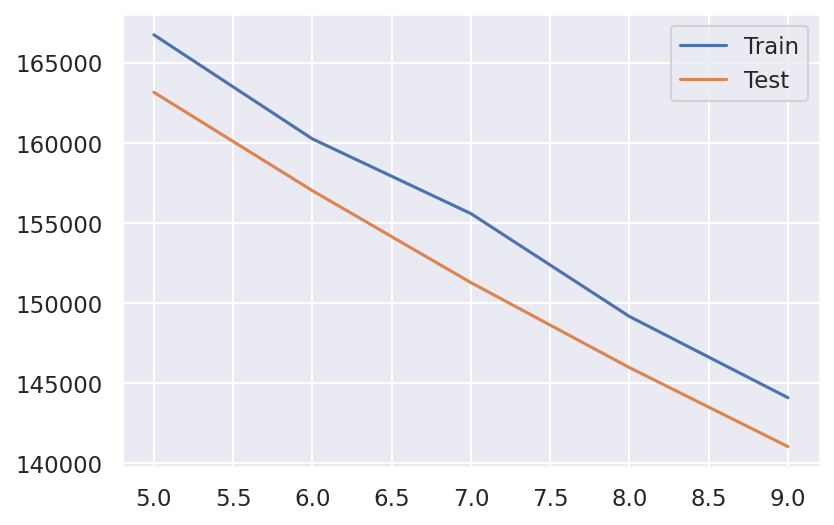

========================= Training KD Tree =========================
CPU times: user 36.7 s, sys: 29.8 s, total: 1min 6s
Wall time: 8.29 s


In [69]:
%%time
results_101 = auxiliary_model_analysis(cifar101_scores, X_test, outlier_scores, LABELS)

## GMM

In [76]:
results_101["GMM"]["metrics"]

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
CelebA,82.39,39.880000,63.167135,58.851571,65.286378,59.94,58.861318
SVHN,8.79,6.915000,97.234294,94.751469,97.959753,3.43,94.757837
LSUN_crop,0.00,0.035000,99.999738,99.999741,99.999737,0.00,99.999741
LSUN_resize,0.00,0.060000,99.999530,99.999534,99.999528,0.00,99.999534
Imagenet_crop,0.00,0.060000,99.999833,99.999833,99.999833,0.00,99.999833
Imagenet_resize,0.00,0.035000,99.999947,99.999947,99.999947,0.00,99.999947
iSUN,0.00,0.041807,99.999575,99.999536,99.999617,0.00,99.999536
Gaussian,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
Uniform,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
All Images,0.00,0.048505,99.999728,99.999945,99.998663,0.00,99.999945


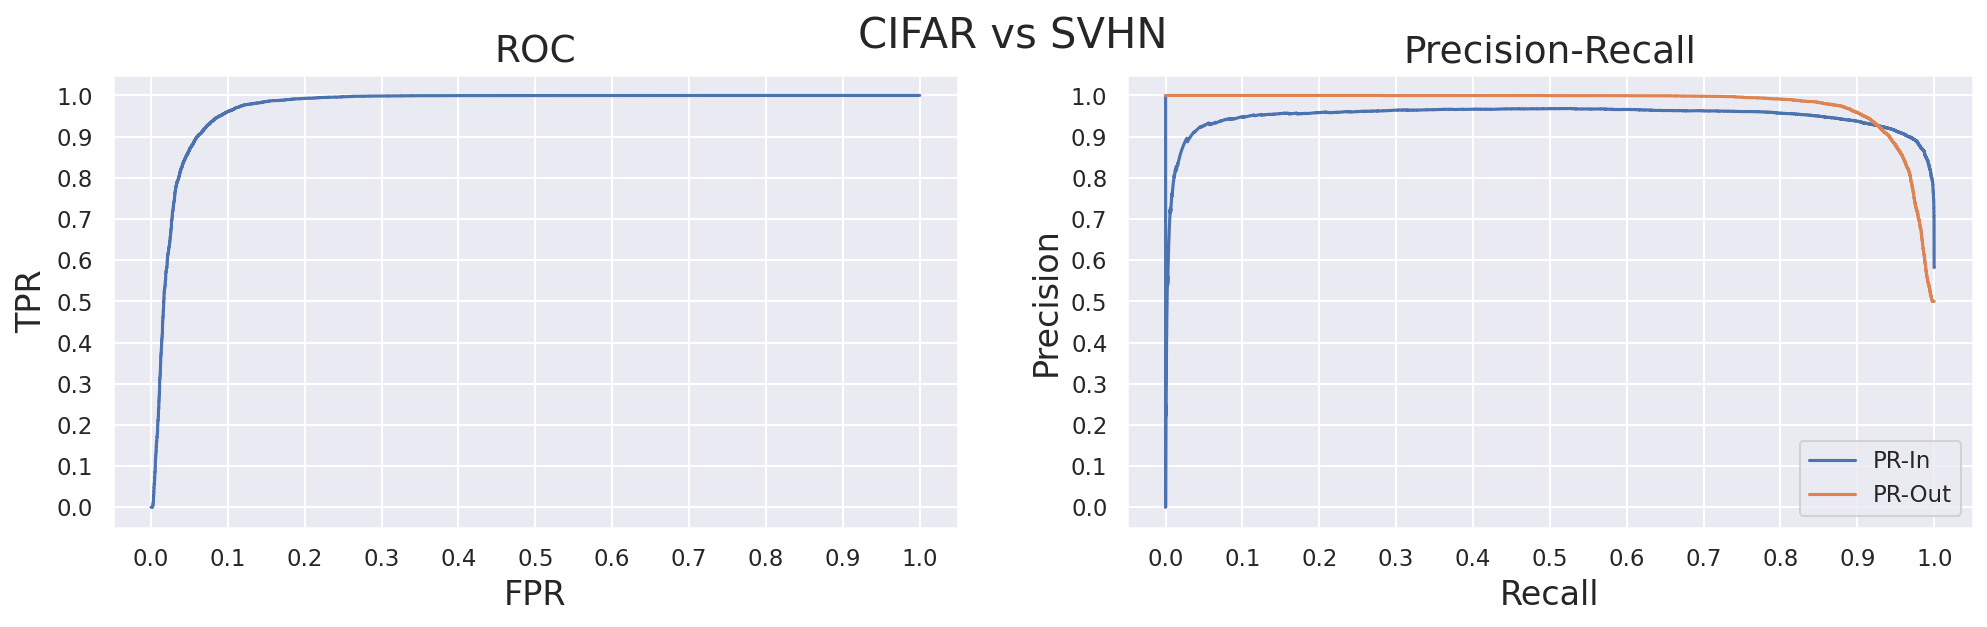

CIFAR vs SVHN
----------------
ROC-AUC: 97.2343
PR-AUC (In/Out): 94.7515 / 97.9598
FPR (95% TPR): 8.79%
Detection Error: 6.91%


{'fpr_tpr95': 0.0879,
 'de': 0.06914999999999999,
 'roc_auc': 0.97234294,
 'pr_auc_in': 0.9475146918666616,
 'pr_auc_out': 0.9795975314006848,
 'fpr_tpr80': 0.0343,
 'ap': 0.9475783747991684}

In [77]:
ood_metrics(-results_101["GMM"]["test_scores"], -results_101["GMM"]["ood_scores"][1], names=(LABELS[1], LABELS[3]), plot=True, verbose=True)

### Validation Check

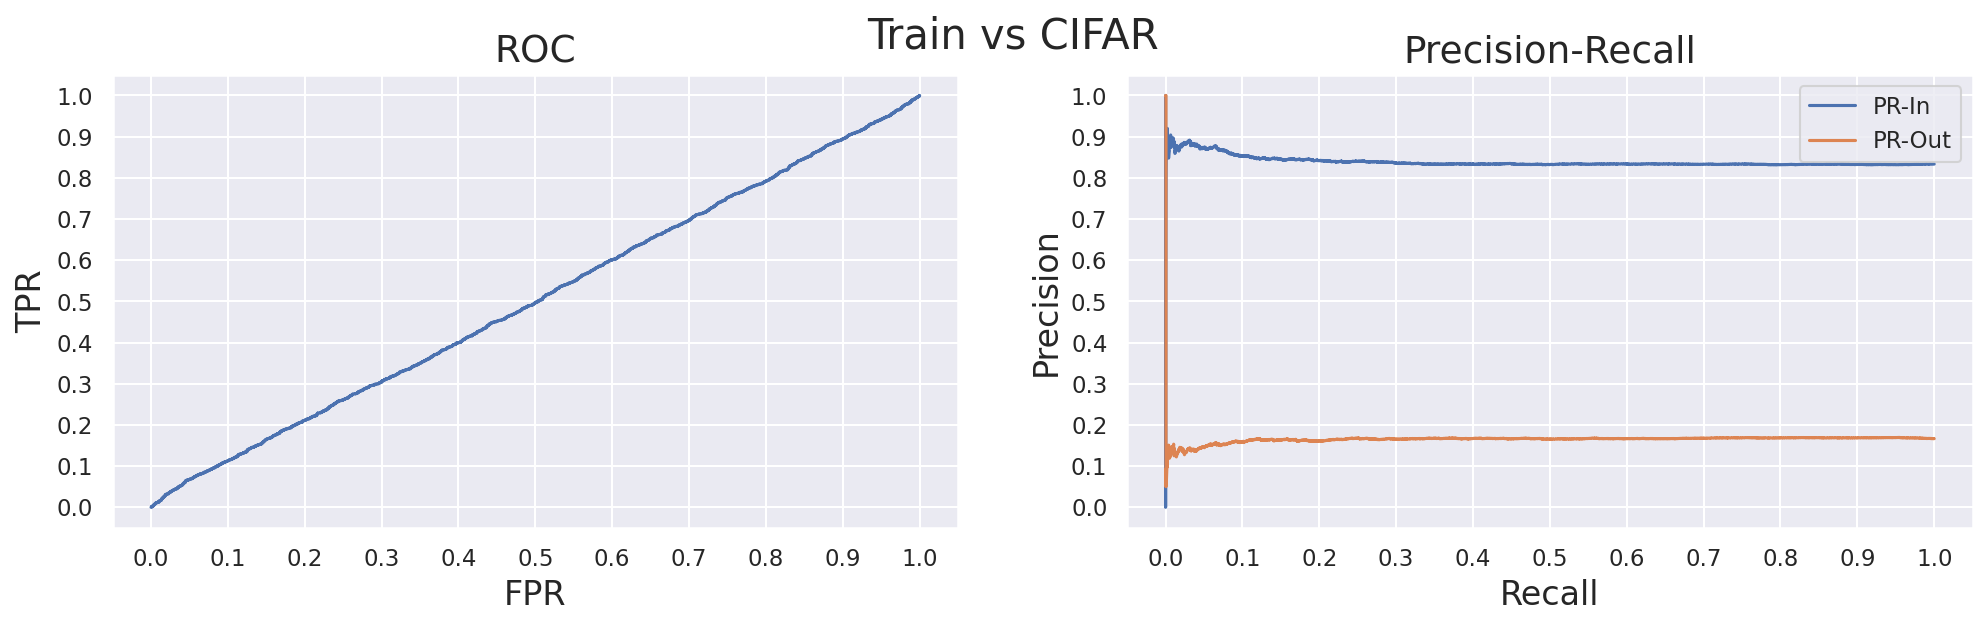

Train vs CIFAR
----------------
ROC-AUC: 50.2460
PR-AUC (In/Out): 83.8841 / 16.5096
FPR (95% TPR): 95.85%
Detection Error: 49.01%


{'fpr_tpr95': 0.9585,
 'de': 0.4901,
 'roc_auc': 0.5024598,
 'pr_auc_in': 0.8388407331190856,
 'pr_auc_out': 0.1650958242455523,
 'fpr_tpr80': 0.7995,
 'ap': 0.8389263704392}

In [78]:
ood_metrics(-results_101["GMM"]["train_scores"], -results_101["GMM"]["test_scores"], names=(LABELS[0], LABELS[1]), plot=True, verbose=True)

## Flow Models

In [79]:
results_101["Flow"]["metrics"]

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
CelebA,44.70,22.185000,82.101413,71.568998,86.349954,25.20,71.576612
SVHN,83.36,33.845000,70.473661,66.196646,68.662378,50.96,66.206054
LSUN_crop,99.79,50.000000,9.128769,31.814593,31.723790,98.57,31.817553
LSUN_resize,90.83,47.585000,48.233308,45.762184,53.264034,74.94,45.767868
Imagenet_crop,98.30,49.980000,17.708814,33.621261,34.297438,96.20,33.624691
Imagenet_resize,91.43,47.650000,51.583081,48.722182,54.237824,74.52,48.728786
iSUN,91.45,47.896387,48.716984,43.713305,55.518835,76.34,43.719778
Gaussian,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
Uniform,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
All Images,98.54,50.000000,34.774426,75.827100,12.164237,93.86,75.828727


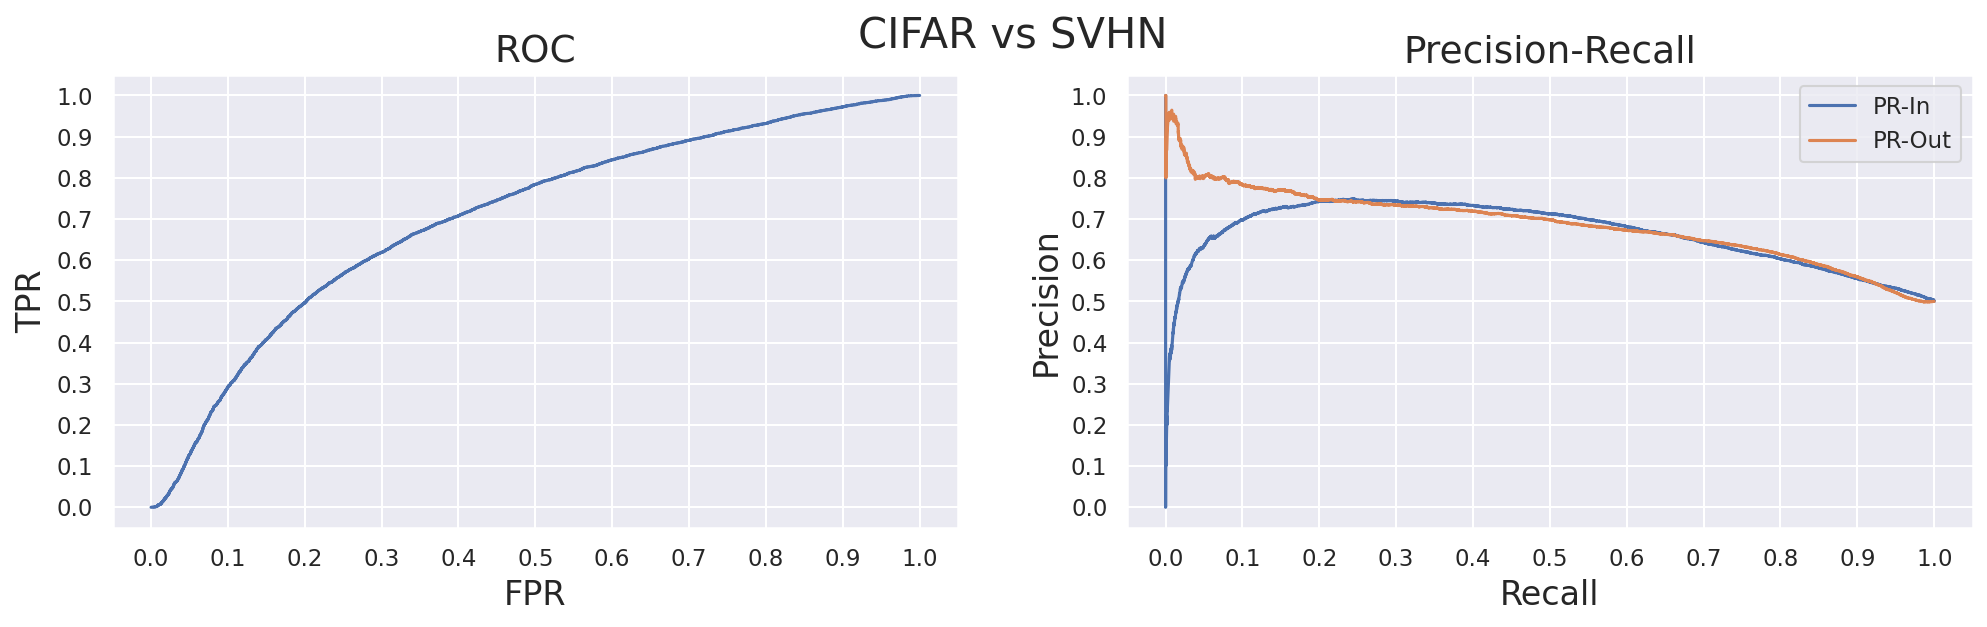

CIFAR vs SVHN
----------------
ROC-AUC: 70.4737
PR-AUC (In/Out): 66.1966 / 68.6624
FPR (95% TPR): 83.36%
Detection Error: 33.85%


{'fpr_tpr95': 0.8336,
 'de': 0.33845000000000003,
 'roc_auc': 0.7047366099999999,
 'pr_auc_in': 0.6619664598953636,
 'pr_auc_out': 0.6866237846321772,
 'fpr_tpr80': 0.5096,
 'ap': 0.6620605405778104}

In [80]:
ood_metrics(-results_101["Flow"]["test_scores"], -results_101["Flow"]["ood_scores"][1], names=(LABELS[1], LABELS[3]), plot=True, verbose=True)

### Validation Check

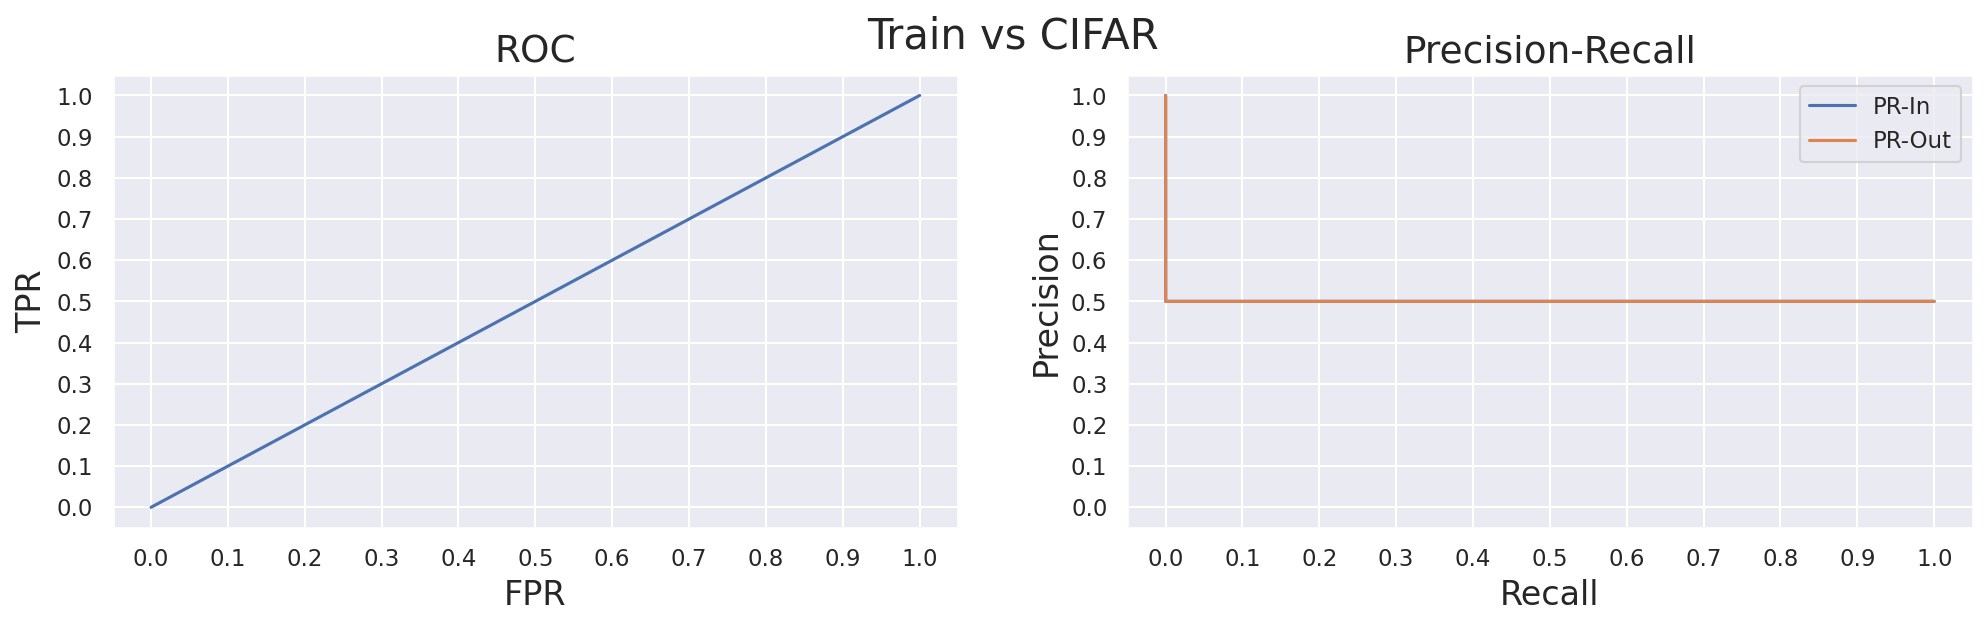

Train vs CIFAR
----------------
ROC-AUC: 50.0000
PR-AUC (In/Out): 50.0025 / 50.0025
FPR (95% TPR): 94.90%
Detection Error: 50.00%


{'fpr_tpr95': 0.949,
 'de': 0.5,
 'roc_auc': 0.49999999999999994,
 'pr_auc_in': 0.5000249999999999,
 'pr_auc_out': 0.500025,
 'fpr_tpr80': 0.7911,
 'ap': 0.5}

In [54]:
ood_metrics(-results_101["Flow"]["train_scores"], -results_101["Flow"]["test_scores"], names=(LABELS[0], LABELS[1]), plot=True, verbose=True)

## KD Trees w/ k=5

In [55]:
results_101["KD"]["metrics"]

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
CelebA,71.75,35.500000,66.909656,59.388071,71.573484,50.34,59.397832
SVHN,2.15,3.445000,99.394959,99.372049,99.425396,0.46,99.372086
LSUN_crop,0.60,1.300000,99.874485,99.863091,99.887790,0.08,99.863099
LSUN_resize,1.23,2.175000,99.681084,99.619928,99.727310,0.36,99.619957
Imagenet_crop,1.08,1.870000,99.711875,99.652568,99.756178,0.35,99.652595
Imagenet_resize,0.64,1.425000,99.844474,99.822790,99.864423,0.12,99.822801
iSUN,1.00,1.871961,99.748554,99.668836,99.805055,0.28,99.668863
Gaussian,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
Uniform,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
All Images,0.88,1.771589,99.772612,99.945742,99.295389,0.23,99.945742


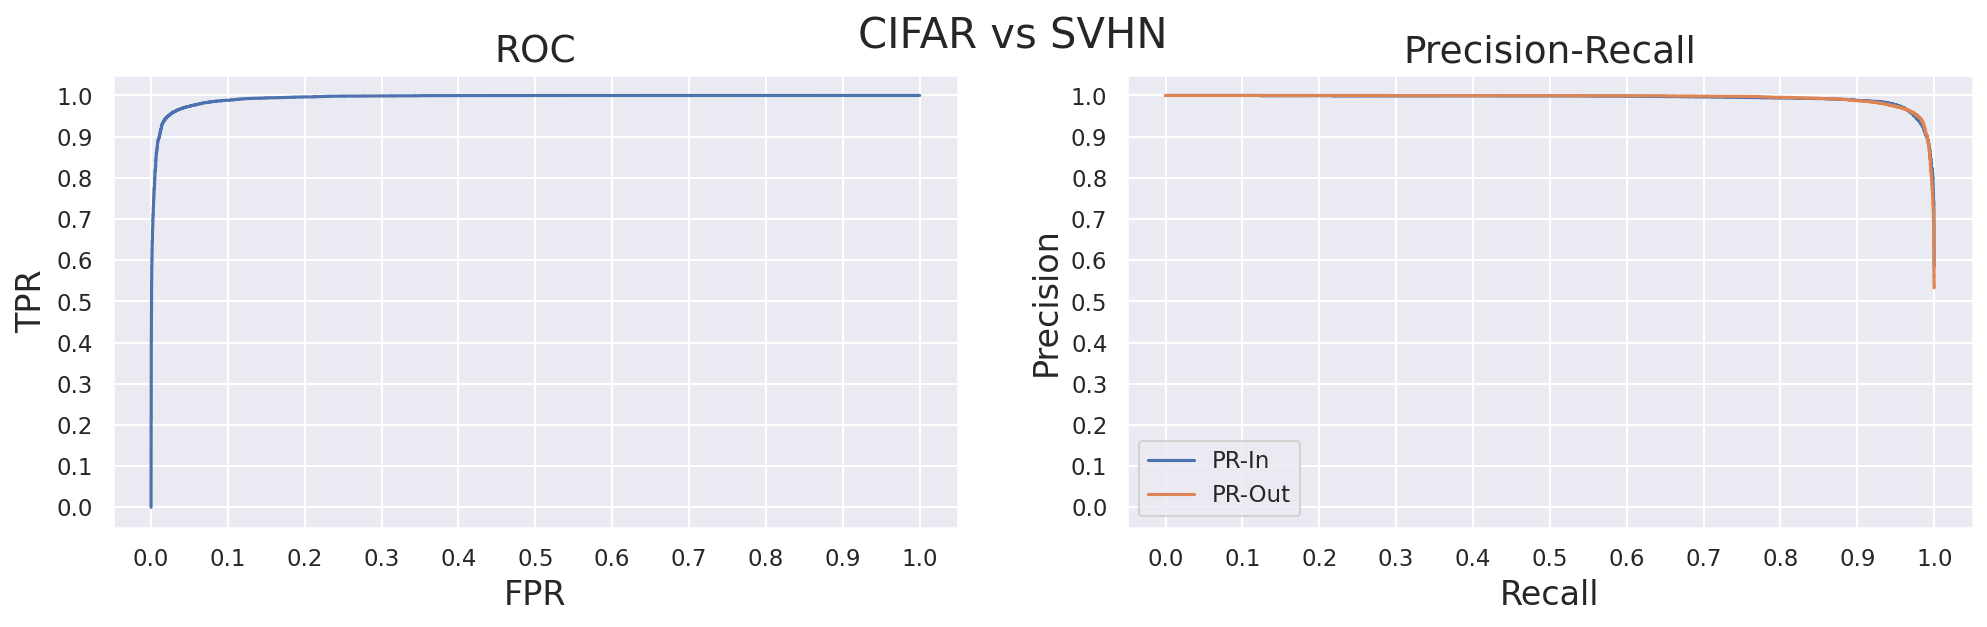

CIFAR vs SVHN
----------------
ROC-AUC: 99.3950
PR-AUC (In/Out): 99.3720 / 99.4254
FPR (95% TPR): 2.15%
Detection Error: 3.45%


{'fpr_tpr95': 0.0215,
 'de': 0.03445000000000001,
 'roc_auc': 0.9939495899999999,
 'pr_auc_in': 0.99372049261641,
 'pr_auc_out': 0.9942539585281004,
 'fpr_tpr80': 0.0046,
 'ap': 0.9937208614594568}

In [57]:
ood_metrics(results_101["KD"]["test_scores"], results_101["KD"]["ood_scores"][1], names=(LABELS[1], LABELS[3]), plot=True, verbose=True)

### Validation Check

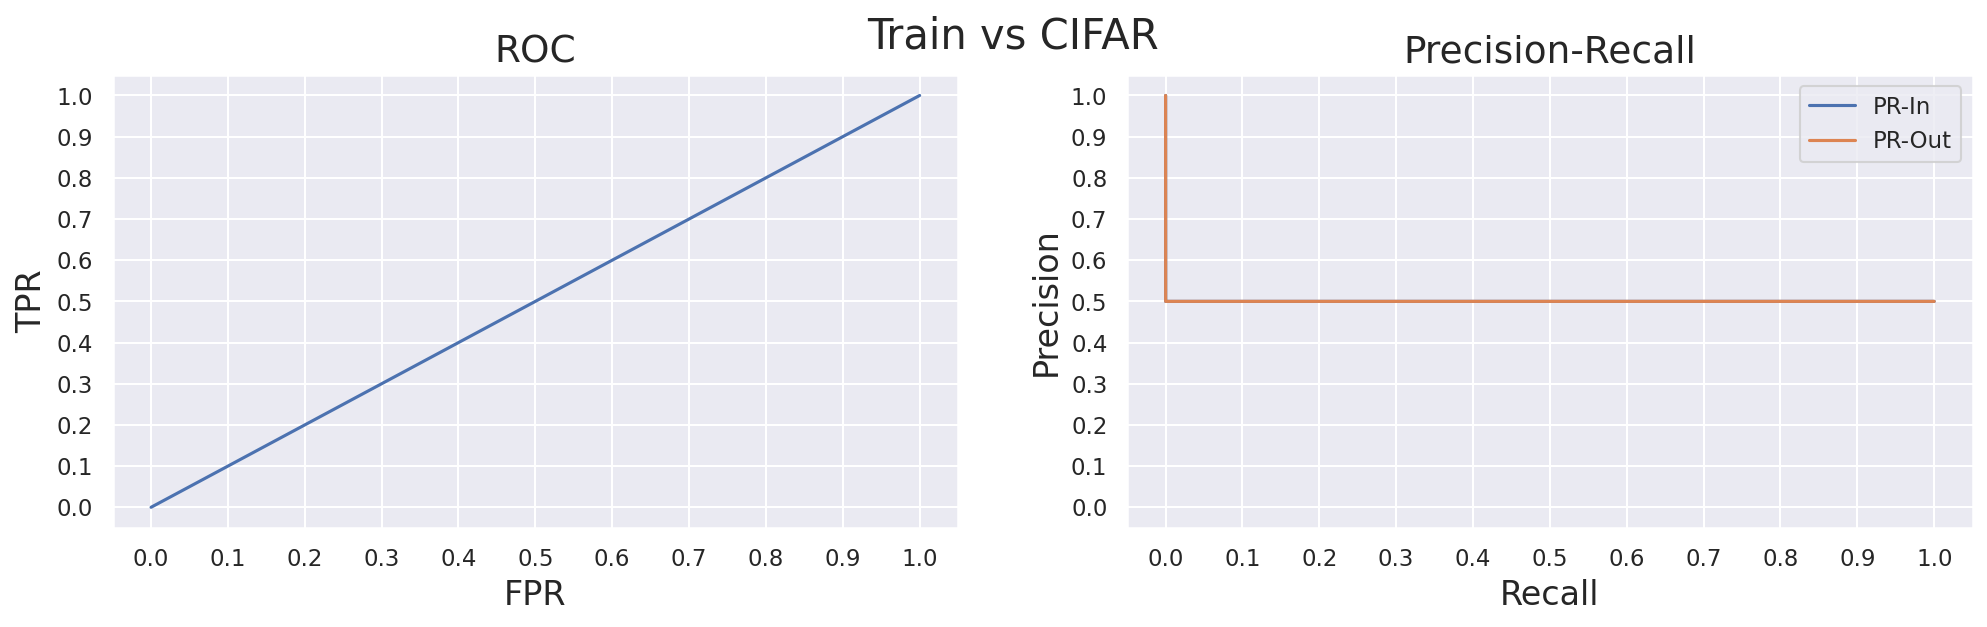

Train vs CIFAR
----------------
ROC-AUC: 50.0000
PR-AUC (In/Out): 50.0025 / 50.0025
FPR (95% TPR): 94.91%
Detection Error: 50.00%


{'fpr_tpr95': 0.9491,
 'de': 0.5,
 'roc_auc': 0.5,
 'pr_auc_in': 0.5000249999999999,
 'pr_auc_out': 0.500025,
 'fpr_tpr80': 0.7911,
 'ap': 0.49999999999999994}

In [58]:
ood_metrics(results_101["KD"]["train_scores"], results_101["KD"]["test_scores"], names=(LABELS[0], LABELS[1]), plot=True, verbose=True)

## Flow on CIFAR 10.1

In [296]:
# Density estimation with MADE.
n = cifar101_scores.shape[0]
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[128, 128], activation="elu")

distribution = tfd.TransformedDistribution(
    distribution=tfd.Normal(loc=0., scale=1.),
    bijector=tfb.MaskedAutoregressiveFlow(made),
    event_shape=[10])

# Construct and fit model.
x_ = tfkl.Input(shape=(10,), dtype=tf.float32)
log_prob_ = distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)

model.compile(optimizer=tf.optimizers.Adadelta(learning_rate=0.001),
              loss=lambda _, log_prob: -log_prob)

batch_size = 32
epochs = 100
history = model.fit(
    x=cifar101_scores,
    y=np.zeros((n, 0), dtype=np.float32),
    batch_size=batch_size,
    epochs=epochs,
    steps_per_epoch=n//batch_size,  # Usually `n // batch_size`.
    shuffle=True,
    verbose=True)

Epoch 1/10000
62/62 [==============================] - 0s 5ms/step - loss: 17389.5059
Epoch 2/10000
62/62 [==============================] - 0s 4ms/step - loss: 12344.9541
Epoch 3/10000
62/62 [==============================] - 0s 4ms/step - loss: 9882.5723
Epoch 4/10000
62/62 [==============================] - 0s 4ms/step - loss: 8330.2803
Epoch 5/10000
62/62 [==============================] - 0s 4ms/step - loss: 7272.9077
Epoch 6/10000
62/62 [==============================] - 0s 4ms/step - loss: 6428.7051
Epoch 7/10000
62/62 [==============================] - 0s 4ms/step - loss: 5830.8804
Epoch 8/10000
62/62 [==============================] - 0s 4ms/step - loss: 5296.5679
Epoch 9/10000
62/62 [==============================] - 0s 4ms/step - loss: 4889.8574
Epoch 10/10000
62/62 [==============================] - 0s 4ms/step - loss: 4528.6660
Epoch 11/10000
62/62 [==============================] - 0s 5ms/step - loss: 4244.2822
Epoch 12/10000
62/62 [==============================] - 0s 5m

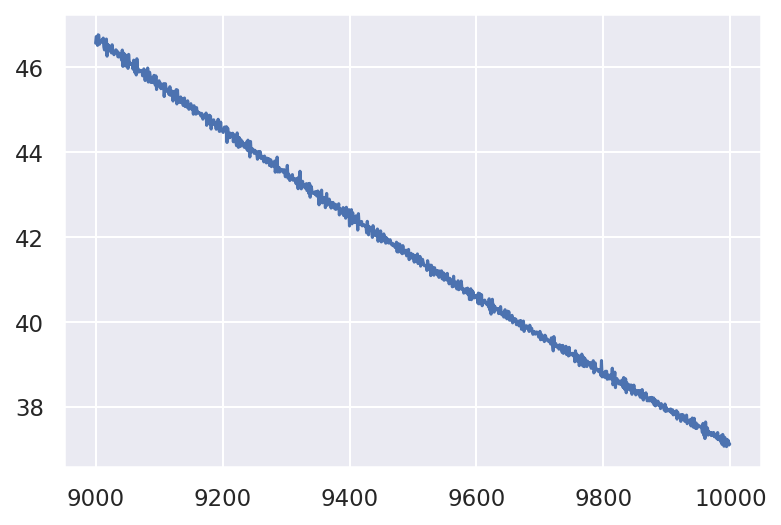

In [292]:
start_idx=90
plt.plot(range(start_idx, epochs), history.history["loss"][start_idx:])
# plt.yscale("log")

In [293]:
%%time
train_score = distribution.log_prob(cifar101_scores, dtype=np.float32).numpy()
test_score = distribution.log_prob(inlier_scores, dtype=np.float32).numpy()
ood_scores = [distribution.log_prob(ood, dtype=np.float32).numpy() for ood in outlier_scores]

CPU times: user 148 ms, sys: 24.4 ms, total: 172 ms
Wall time: 165 ms


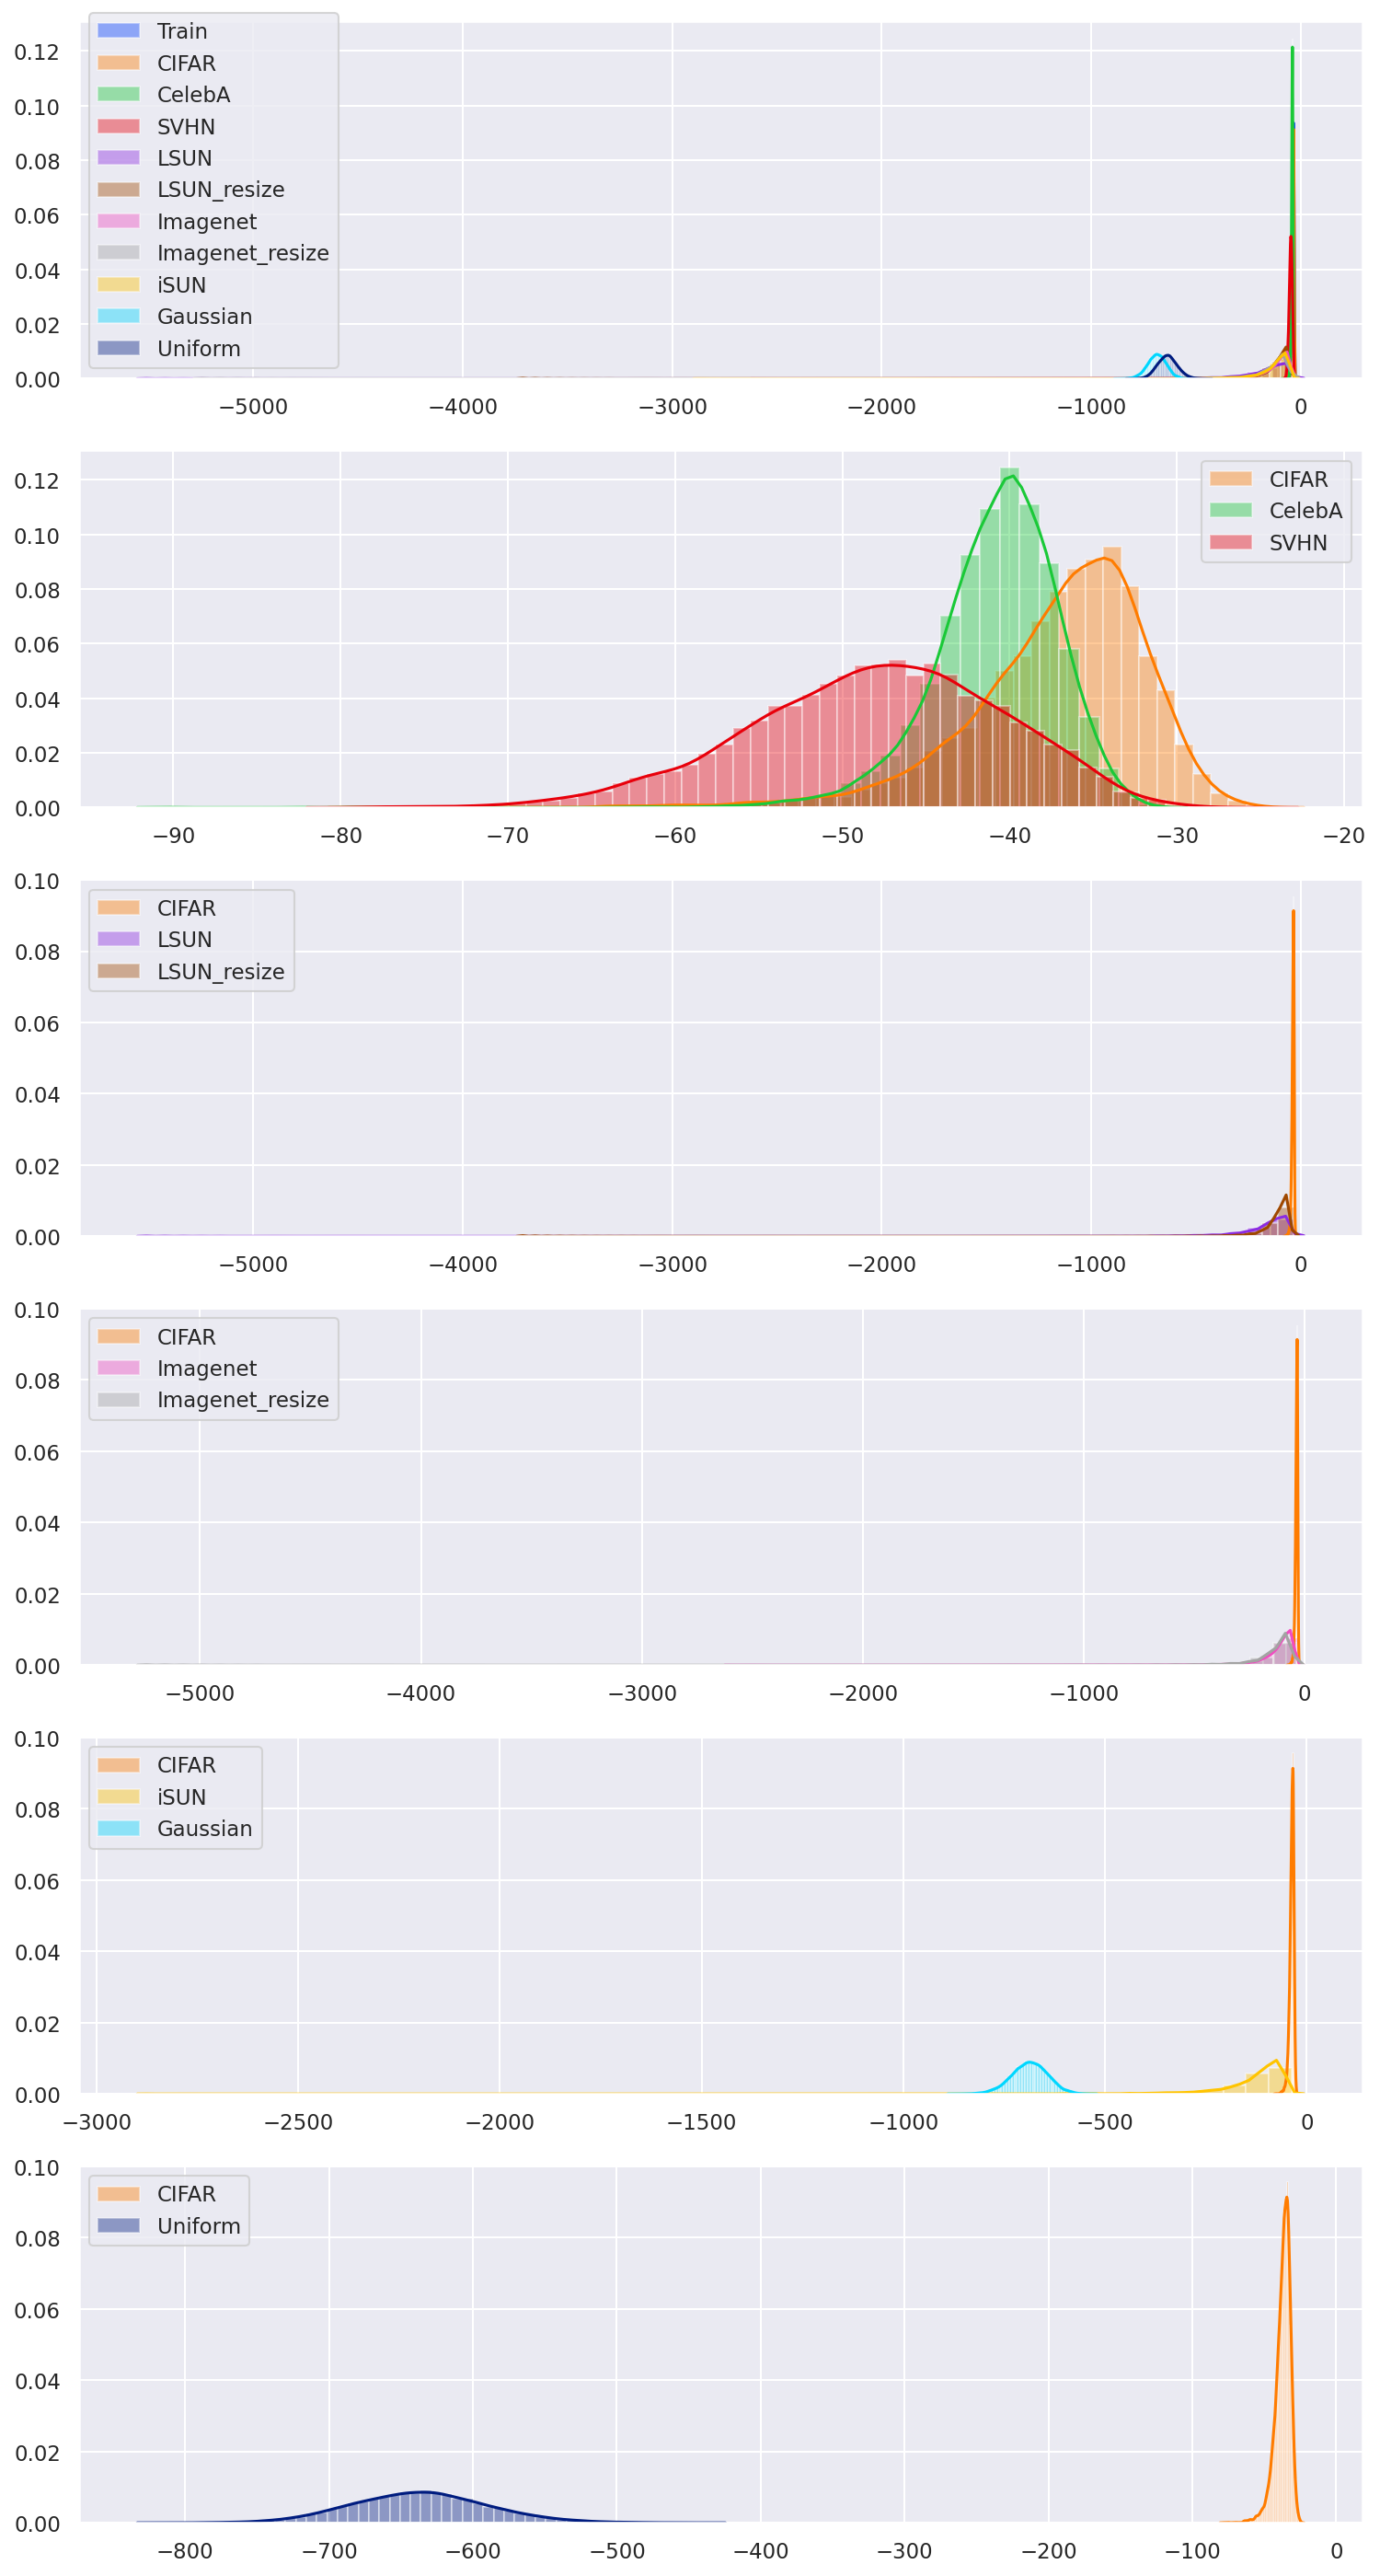

In [294]:
evaluate_model(train_score, test_score, ood_scores, labels=LABELS)

In [295]:
for idx, _score in enumerate(ood_scores):
    ood_metrics(-test_score, -_score, names=(LABELS[1], LABELS[idx+2]),
                    plot=False, verbose=True)
    print()

CIFAR vs CelebA
----------------
ROC-AUC: 0.7534
PR-AUC (In/Out): 0.6563 / 0.8062
FPR (95% TPR) Prec: 0.5595

CIFAR vs SVHN
----------------
ROC-AUC: 0.8878
PR-AUC (In/Out): 0.8776 / 0.8818
FPR (95% TPR) Prec: 0.4860

CIFAR vs LSUN
----------------
ROC-AUC: 0.9950
PR-AUC (In/Out): 0.9957 / 0.9943
FPR (95% TPR) Prec: 0.0111

CIFAR vs LSUN_resize
----------------
ROC-AUC: 0.9966
PR-AUC (In/Out): 0.9968 / 0.9966
FPR (95% TPR) Prec: 0.0138

CIFAR vs Imagenet
----------------
ROC-AUC: 0.9949
PR-AUC (In/Out): 0.9954 / 0.9947
FPR (95% TPR) Prec: 0.0208

CIFAR vs Imagenet_resize
----------------
ROC-AUC: 0.9984
PR-AUC (In/Out): 0.9985 / 0.9984
FPR (95% TPR) Prec: 0.0059

CIFAR vs iSUN
----------------
ROC-AUC: 0.9976
PR-AUC (In/Out): 0.9975 / 0.9979
FPR (95% TPR) Prec: 0.0100

CIFAR vs Gaussian
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.0000

CIFAR vs Uniform
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.000

In [ ]:
ood_metrics(-train_score, -test_score, names=(LABELS[0], LABELS[1]),plot=True, verbose=True)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    6.5s finished


Best: 1.044107 using {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
---------------------------------------------------------------------------
0.911419 (0.165316) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
1.044107 (0.186802) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
1.035158 (0.163404) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 6}
1.031568 (0.201130) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 8}
0.973064 (0.178820) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 10}
0.904938 (0.243008) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 12}
0.773552 (0.202081) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 14}
0.724550 (0.173075) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 16}
0.529639 (0.198457) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 18}
0.533186 (0.216133) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 20}
CPU times:

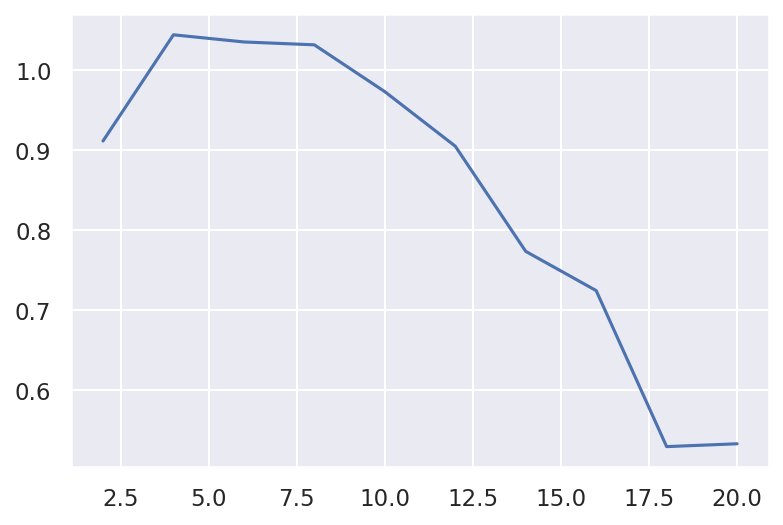

In [26]:
%%time
alt_gmm_clf = train_gmm(cifar101_scores, verbose=True)

In [36]:
print("---Likelihoods---")
print("Training: {:.3f}".format(alt_gmm_clf.score(cifar101_scores)))
print("{}: {:.3f}".format(LABELS[1], alt_gmm_clf.score(inlier_scores)))

for name, ood in zip(LABELS[2:], outlier_scores):
    print("{}: {:.3f}".format(name, alt_gmm_clf.score(ood)))

---Likelihoods---
Training: 1.249
CIFAR: 1.200
CelebA: -1.049
SVHN: -6.498
LSUN: -1167.097
LSUN_resize: -551.759
Imagenet: -641.380
Imagenet_resize: -728.180
iSUN: -618.080
Gaussian: -956.259
Uniform: -604.097


In [28]:
%%time
train_score = alt_gmm_clf.score_samples(X_train)
test_score = alt_gmm_clf.score_samples(inlier_scores)
ood_scores = [alt_gmm_clf.score_samples(ood) for ood in outlier_scores]

CPU times: user 2.99 s, sys: 3.86 s, total: 6.85 s
Wall time: 148 ms


### OOD Evaluation

In [30]:
for idx, _score in enumerate(ood_scores):
    ood_metrics(-test_score, -_score, names=(LABELS[1], LABELS[idx+2]),
                    plot=False, verbose=True)
    print()

CIFAR vs CelebA
----------------
ROC-AUC: 0.7101
PR-AUC (In/Out): 0.6753 / 0.7162
FPR (95% TPR) Prec: 0.7605

CIFAR vs SVHN
----------------
ROC-AUC: 0.9598
PR-AUC (In/Out): 0.9326 / 0.9693
FPR (95% TPR) Prec: 0.1297

CIFAR vs LSUN
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.0000

CIFAR vs LSUN_resize
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.0000

CIFAR vs Imagenet
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.0000

CIFAR vs Imagenet_resize
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.0000

CIFAR vs iSUN
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.0000

CIFAR vs Gaussian
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.0000

CIFAR vs Uniform
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.000

### Validation Check

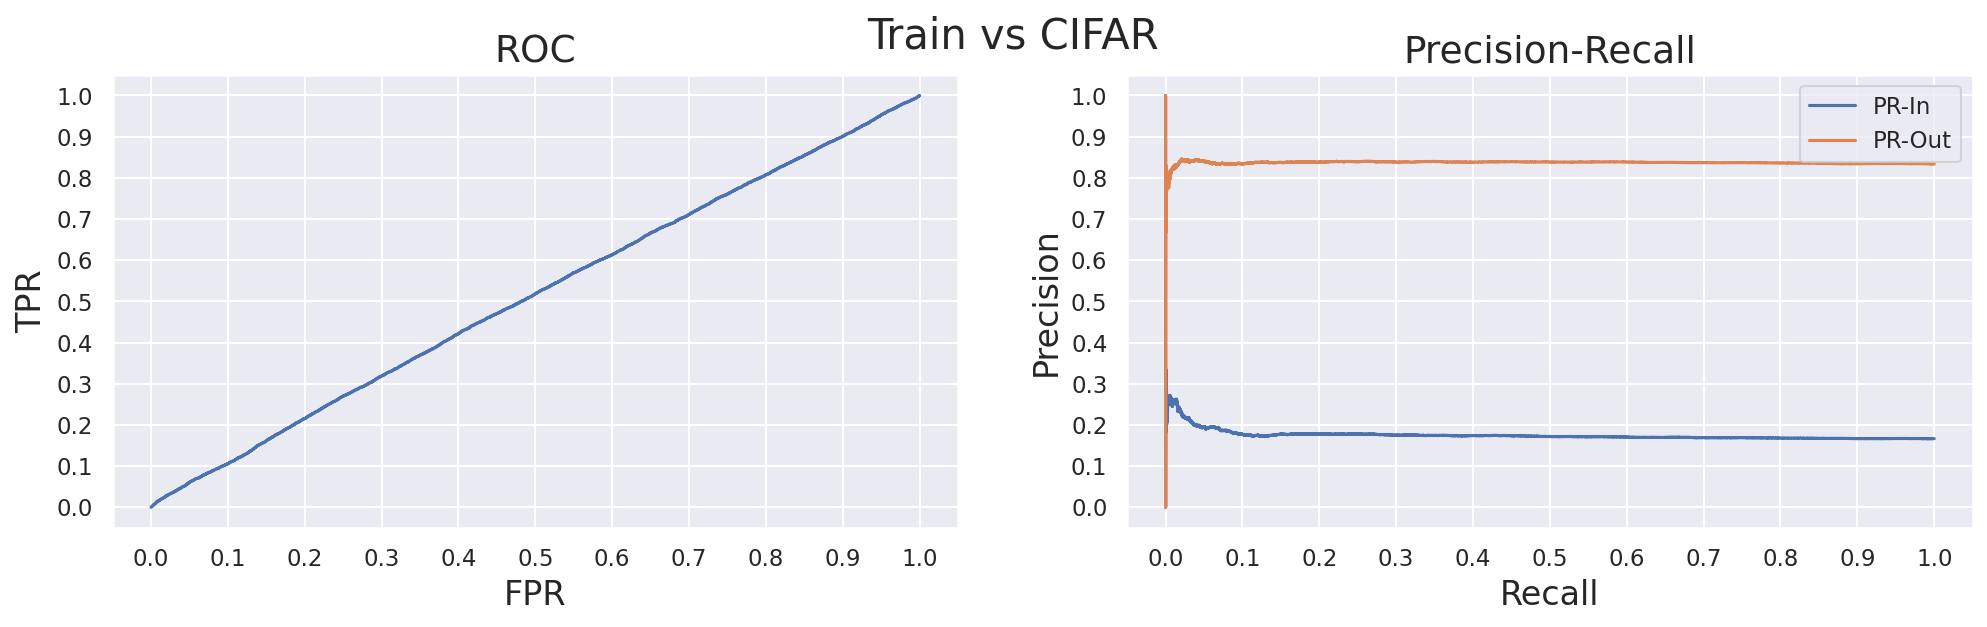

Train vs CIFAR
----------------
ROC-AUC: 51.2392
PR-AUC (In/Out): 17.5089 / 83.6974
FPR (95% TPR): 94.63%
Detection Error: 48.82%


{'roc_auc': 0.512392412,
 'fpr_tpr95': 0.94632,
 'fpr_tpr80': 0.79164,
 'pr_auc_in': 0.17508871721019983,
 'pr_auc_out': 0.836974124893962,
 'ap': 0.17517549811585292,
 'de': 0.48823}

In [116]:
ood_metrics(-train_score, -test_score, names=(LABELS[0], LABELS[1]),plot=True, verbose=True)

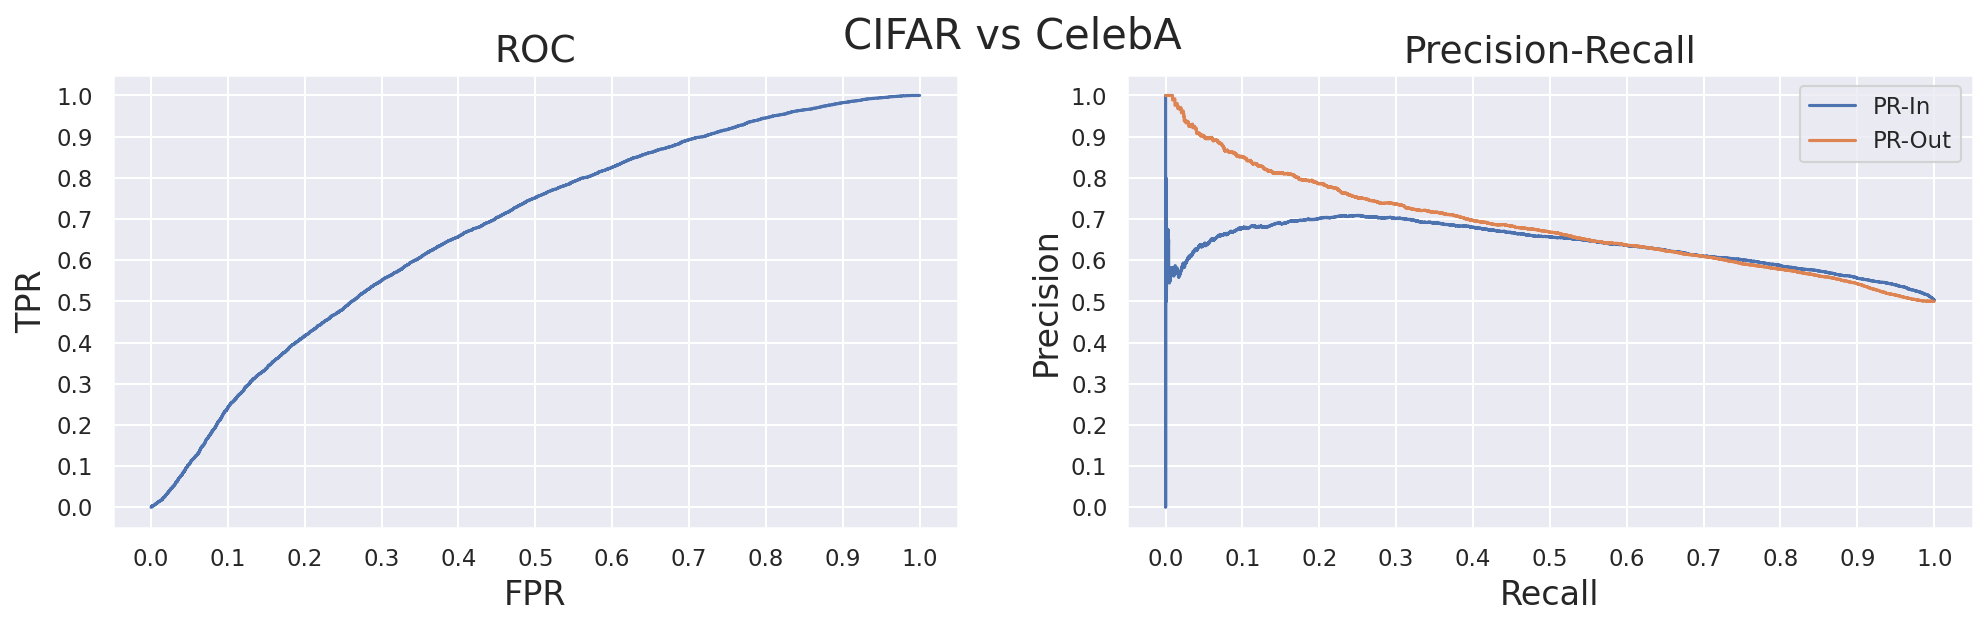

CIFAR vs CelebA
----------------
ROC-AUC: 67.6670
PR-AUC (In/Out): 63.6222 / 68.2675
FPR (95% TPR): 80.74%
Detection Error: 36.98%


{'roc_auc': 0.67666962,
 'fpr_tpr95': 0.8074,
 'fpr_tpr80': 0.56,
 'pr_auc_in': 0.6362215278205559,
 'pr_auc_out': 0.6826746257004107,
 'ap': 0.6363524542778737,
 'de': 0.36985}

In [115]:
ood_metrics(-test_score, -ood_scores[0], names=(LABELS[1], LABELS[2]), plot=True, verbose=True)

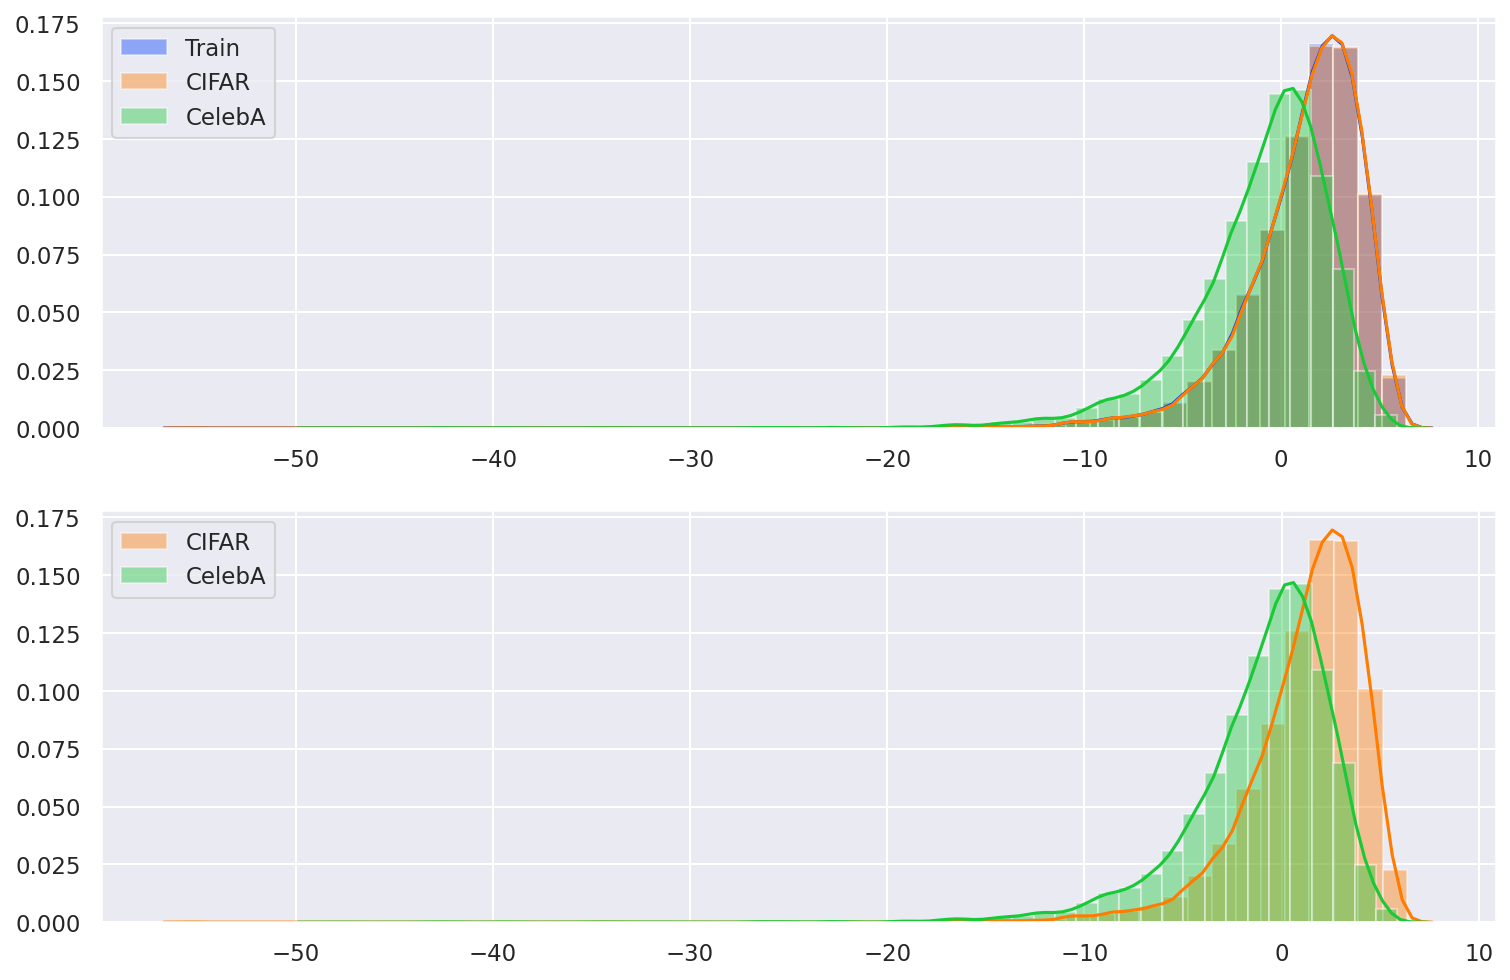

In [33]:
evaluate_model(train_score, test_score, ood_scores[0:1], labels=LABELS)